In [ ]:
""" File for stitching together 2d images (.png) and saving as 3d volumes (.npy) """

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import tqdm

# img_dir = "data/small_data_2d/original"
img_dir="/Volumes/LaCie/bigdata/imgs"
# mask_dir = "data/small_data_2d/ground_truth"
mask_dir="/Volumes/LaCie/bigdata/gts"
# subdirs = ["train", "valid", "test"]
cell_mask_dir="/Volumes/LaCie/bigdata/masks"

In [3]:
def get_z_y_x(file_name, pattern):
    """ get z, y, x from file name (uses basename of file_name)"""
    file_name = os.path.basename(file_name)
    match = re.match(pattern, file_name)
    if match:
        if len(match.groups()) != 3:
            return None
        z, y, x = match.groups()
        return int(z), int(y), int(x)
    else:
        return None
    
def get_img_by_coords(z, y, x, img_files, img_pattern):
    """ get path of image by z, y, x """
    for i in range(len(img_files)):
        img_file = img_files[i]
        try:
            z_, y_, x_ = get_z_y_x(img_file, img_pattern)
        except:
            continue
        if z == z_ and y == y_ and x == x_:
            return cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    return None

def get_3d_slice_single_img(z,y,x, img_files, img_pattern, depth=1, width=512, height=512):
    img_3d = np.zeros((2*depth+1, width, height))
    for i in range(-depth, depth+1):
        z_coord = z+i
        img = get_img_by_coords(z_coord, y, x, img_files, img_pattern)
        if img is not None:
            img_3d[i+depth] = img
    return img_3d

def get_3d_slice(z,y,x, img_files, mask_files, img_pattern, mask_pattern, depth=1, width=512, height=512):
    """ get 3d slice by z, y, x 
    
    -think of the original image as 3d volume, and each slice is a pixel
    -so we want a column of pixels, with the center pixel being the pixel at z, y, x, and sliding up and down along the z axis
    
    Args:
        z: int, z coordinate
        y: int, y coordinate
        x: int, x coordinate
        img_files: list of str, paths to images
        mask_files: list of str, paths to masks
        img_pattern: str, pattern to extract z, y, x from image file name
        mask_pattern: str, pattern to extract z, y, x from mask file name
        depth: int, how many slices to include above and below the center slice
        width: int, width of each slice
        height: int, height of each slice
    """
    img_3d = np.zeros((2*depth+1, width, height))
    mask_3d = np.zeros((2*depth+1, width, height))
    for i in range(-depth, depth+1):
        z_coord = z+i
        img = get_img_by_coords(z_coord, y, x, img_files, img_pattern)
        mask = get_img_by_coords(z_coord, y, x, mask_files, mask_pattern)
        if img is not None and mask is not None:
            img_3d[i+depth] = img
            mask_3d[i+depth] = mask
    return img_3d, mask_3d

def get_3d_slice_forward(z,y,x, img_files, mask_files, img_pattern, mask_pattern, depth=3, width=512, height=512):
    """ get 3d slice by z, y, x 
    
    -think of the original image as 3d volume, and each slice is a pixel
    -so we want a column of pixels, with the center pixel being the pixel at z, y, x, and sliding up and down along the z axis
    
    Args:
        z: int, z coordinate
        y: int, y coordinate
        x: int, x coordinate
        img_files: list of str, paths to images
        mask_files: list of str, paths to masks
        img_pattern: str, pattern to extract z, y, x from image file name
        mask_pattern: str, pattern to extract z, y, x from mask file name
        depth: int, how many slices to include above and below the center slice
        width: int, width of each slice
        height: int, height of each slice
    """
    img_3d = np.zeros((depth, width, height))
    mask_3d = np.zeros((depth, width, height))
    for i in range(depth):
        z_coord = z+i
        img = get_img_by_coords(z_coord, y, x, img_files, img_pattern)
        mask = get_img_by_coords(z_coord, y, x, mask_files, mask_pattern)
        if img is not None and mask is not None:
            img_3d[i] = img
            mask_3d[i] = mask
    return img_3d, mask_3d

In [3]:
# sort the files by z, y, x (ensure that img and mask files are in the same order)
img_files = os.listdir(img_dir)
mask_files = os.listdir(mask_dir)
cell_mask_files = os.listdir(cell_mask_dir)
mask_pattern=r"sem2dauer_gj_2d_training.vsseg_export_s(\d+)_Y(\d+)_X(\d+).png.png"
img_pattern=r"SEM_dauer_2_image_export_s(\d+)_Y(\d+)_X(\d+).png.png"
cell_mask_pattern=r"20240325_SEM_dauer_2_nr_vnc_neurons_head_muscles.vsseg_export_s(\d+)_Y(\d+)_X(\d+).png"
img_files = [os.path.join(img_dir, f) for f in img_files if f.endswith(".png")]
mask_files = [os.path.join(mask_dir, f) for f in mask_files if f.endswith(".png")]
cell_mask_files = [os.path.join(cell_mask_dir, f) for f in cell_mask_files if f.endswith(".png")]
print(img_files[:10])
print(mask_files[:10])
print(cell_mask_files[:10])

['/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s001_Y8_X13.png.png', '/Volumes/LaCie/bigdata/imgs/._SEM_dauer_2_image_export_s001_Y8_X13.png.png', '/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s014_Y8_X13.png.png', '/Volumes/LaCie/bigdata/imgs/._SEM_dauer_2_image_export_s014_Y8_X13.png.png', '/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s034_Y3_X9.png.png', '/Volumes/LaCie/bigdata/imgs/._SEM_dauer_2_image_export_s034_Y3_X9.png.png', '/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s010_Y7_X5.png.png', '/Volumes/LaCie/bigdata/imgs/._SEM_dauer_2_image_export_s010_Y7_X5.png.png', '/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s006_Y7_X9.png.png', '/Volumes/LaCie/bigdata/imgs/._SEM_dauer_2_image_export_s006_Y7_X9.png.png']
['/Volumes/LaCie/bigdata/gts/sem2dauer_gj_2d_training.vsseg_export_s043_Y14_X9.png.png', '/Volumes/LaCie/bigdata/gts/._sem2dauer_gj_2d_training.vsseg_export_s043_Y14_X9.png.png', '/Volumes/LaCie/bigdata/gts/sem2dauer_gj_2d_training.vss

(5, 512, 512)


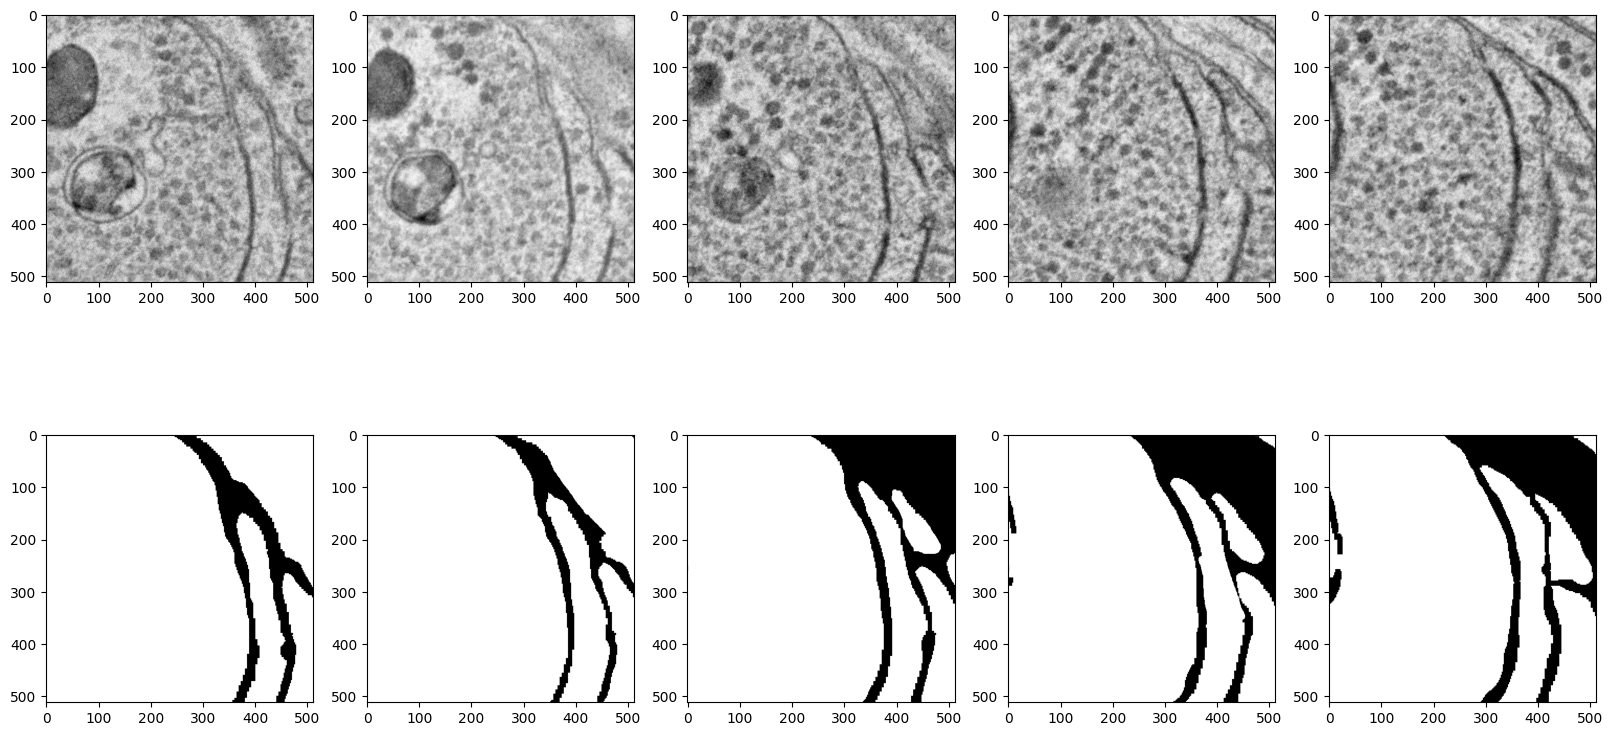

In [12]:
# sanity check: test that image and mask actually match
depth=2
img_3d = get_3d_slice_single_img(z, y, x, img_files, img_pattern, depth=depth)
mask_3d = get_3d_slice_single_img(z, y, x, mask_files, mask_pattern, depth=depth)
cell_mask_3d = get_3d_slice_single_img(z, y, x, cell_mask_files, cell_mask_pattern, depth=depth)
filtered_cell_mask_3d = cell_mask_3d.copy()
filtered_cell_mask_3d[filtered_cell_mask_3d!=0]=1
img_3d= img_3d.astype(np.uint8)
print(filtered_cell_mask_3d.shape)
depth = 2*depth+1
fig, ax = plt.subplots(2, depth, figsize=(20, 10))
for i in range(depth):
    ax[0, i].imshow(img_3d[i], cmap='gray')
    ax[1, i].imshow(filtered_cell_mask_3d[i], cmap='gray')
plt.show()

In [13]:
print(len(img_files), len(mask_files))

5390 5390


In [14]:
save_dir = "/Volumes/LaCie/512_depth_5"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(os.path.join(save_dir, "original")):
    os.makedirs(os.path.join(save_dir, "original"))
if not os.path.exists(os.path.join(save_dir, "ground_truth")):
    os.makedirs(os.path.join(save_dir, "ground_truth"))
if not os.path.exists(os.path.join(save_dir, "cell_mask")):
    os.makedirs(os.path.join(save_dir, "cell_mask"))

In [15]:
# save 3d slices
depth = 2 # (5, 512, 512)
total = len(img_files)
# total=2
alternate=True
for i in range(total):
    print(f"saved {i}/{total}", end="\r")
    try:
        z, y, x = get_z_y_x(img_files[i], img_pattern)
    except:
        continue
    try:
        img_3d = get_3d_slice_single_img(z, y, x, img_files, img_pattern, depth=depth)
        mask_3d = get_3d_slice_single_img(z, y, x, mask_files, mask_pattern, depth=depth)
        cell_mask_3d = get_3d_slice_single_img(z, y, x, cell_mask_files, cell_mask_pattern, depth=depth)
        filtered_cell_mask_3d = cell_mask_3d.copy()
        filtered_cell_mask_3d[filtered_cell_mask_3d!=0]=1
    except:
        print(f"no 3d slice available for {z}{y}{x}")
        continue
    img_3d = img_3d.astype(np.uint8)
    mask_3d = mask_3d.astype(np.uint8)
    filtered_cell_mask_3d = filtered_cell_mask_3d.astype(np.uint8)
    if i == 0:
        print(img_3d.shape, mask_3d.shape, filtered_cell_mask_3d.shape)
    np.save(os.path.join(save_dir, "original", f"z{z}_y{y}_x{x}.npy"), img_3d)
    np.save(os.path.join(save_dir, "ground_truth", f"z{z}_y{y}_x{x}.npy"), mask_3d)
    np.save(os.path.join(save_dir, "cell_mask", f"z{z}_y{y}_x{x}.npy"), filtered_cell_mask_3d)

(5, 512, 512) (5, 512, 512) (5, 512, 512)


In [16]:
files = os.listdir(os.path.join(save_dir, "original"))
print(len(files)) # 243 training samples (some may overlap a bit, fine for now)

2695


# Train Test Split

In [4]:
# data_dir = "data/small_data_512" # CHANGE ME
data_dir = "/Volumes/LaCie/512_depth_5"

# load data
img_dir = os.path.join(data_dir, "original")
mask_dir = os.path.join(data_dir, "ground_truth")
cell_mask_dir = os.path.join(data_dir, "cell_mask")
img_paths = os.listdir(img_dir)
mask_paths = os.listdir(mask_dir)
cell_mask_paths = os.listdir(cell_mask_dir)
imgs = [np.load(os.path.join(img_dir, img_path)) for img_path in img_paths if img_path.endswith(".npy")]
masks = [np.load(os.path.join(mask_dir, mask_path)) for mask_path in mask_paths if mask_path.endswith(".npy")]
cell_masks = [np.load(os.path.join(cell_mask_dir, cell_mask_path)) for cell_mask_path in cell_mask_paths if cell_mask_path.endswith(".npy")]

In [5]:
# create subdirectories for train, valid, test
if not os.path.exists(os.path.join(img_dir, "train")):
    os.makedirs(os.path.join(img_dir, "train"))
if not os.path.exists(os.path.join(img_dir, "valid")):
    os.makedirs(os.path.join(img_dir, "valid"))
if not os.path.exists(os.path.join(img_dir, "test")):
    os.makedirs(os.path.join(img_dir, "test"))   
if not os.path.exists(os.path.join(mask_dir, "train")):
    os.makedirs(os.path.join(mask_dir, "train"))
if not os.path.exists(os.path.join(mask_dir, "valid")):
    os.makedirs(os.path.join(mask_dir, "valid"))
if not os.path.exists(os.path.join(mask_dir, "test")):
    os.makedirs(os.path.join(mask_dir, "test"))

In [6]:
# split data into train, valid, test
num_imgs = len(imgs)
indices = np.arange(num_imgs)
np.random.shuffle(indices)
train_indices = indices[:int(0.8*num_imgs)]
valid_indices = indices[int(0.8*num_imgs):int(0.9*num_imgs)]
test_indices = indices[int(0.9*num_imgs):]
print(len(train_indices), len(valid_indices), len(test_indices))
imgs = np.array(imgs)
masks = np.array(masks)
print("imgs shape: ", imgs.shape)

2156 269 270
imgs shape:  (2695, 5, 512, 512)


In [7]:
train_imgs = imgs[train_indices]
valid_imgs = imgs[valid_indices]
test_imgs = imgs[test_indices]

train_masks = masks[train_indices]
valid_masks = masks[valid_indices]
test_masks = masks[test_indices]
print(f"Train: {train_masks.shape}, {train_imgs.shape}") # (num_imgs, 512, 512, 3)
print(f"Valid: {valid_masks.shape}, {valid_imgs.shape}")
print(f"Test: {test_masks.shape}, {test_imgs.shape}")

Train: (2156, 5, 512, 512), (2156, 5, 512, 512)
Valid: (269, 5, 512, 512), (269, 5, 512, 512)
Test: (270, 5, 512, 512), (270, 5, 512, 512)


In [8]:
# save imgs
for i,img in tqdm.tqdm(enumerate(train_imgs)):
    np.save(os.path.join(img_dir, "train", f"{i}.npy"), train_imgs[i])
    print(f"Saved train {i}")
for i,img in tqdm.tqdm(enumerate(valid_imgs)):
    np.save(os.path.join(img_dir, "valid", f"{i}.npy"), valid_imgs[i])
    print(f"Saved valid {i}")
for i,img in tqdm.tqdm(enumerate(test_imgs)):
    np.save(os.path.join(img_dir, "test", f"{i}.npy"), test_imgs[i])
    print(f"Saved test {i}")

# save masks
for i,mask in tqdm.tqdm(enumerate(train_masks)):
    np.save(os.path.join(mask_dir, "train", f"{i}.npy"), train_masks[i])
    print(f"Saved train {i}")
for i,mask in tqdm.tqdm(enumerate(valid_masks)):
    np.save(os.path.join(mask_dir, "valid", f"{i}.npy"), valid_masks[i])
    print(f"Saved valid {i}")
for i,mask in tqdm.tqdm(enumerate(test_masks)):
    np.save(os.path.join(mask_dir, "test", f"{i}.npy"), test_masks[i])
    print(f"Saved test {i}")

print("Done")

1it [00:00,  9.50it/s]

Saved train 0
Saved train 1


6it [00:00, 15.22it/s]

Saved train 2
Saved train 3
Saved train 4
Saved train 5
Saved train 6
Saved train 7
Saved train 8
Saved train 9
Saved train 10


18it [00:00, 36.27it/s]

Saved train 11
Saved train 12
Saved train 13
Saved train 14
Saved train 15
Saved train 16
Saved train 17
Saved train 18


31it [00:01, 38.07it/s]

Saved train 19
Saved train 20
Saved train 21
Saved train 22
Saved train 23
Saved train 24
Saved train 25
Saved train 26
Saved train 27
Saved train 28
Saved train 29
Saved train 30


36it [00:01, 32.93it/s]

Saved train 31
Saved train 32
Saved train 33
Saved train 34
Saved train 35
Saved train 36
Saved train 37
Saved train 38
Saved train 39
Saved train 40
Saved train 41


43it [00:01, 38.55it/s]

Saved train 42
Saved train 43
Saved train 44
Saved train 45
Saved train 46


54it [00:01, 36.72it/s]

Saved train 47
Saved train 48
Saved train 49
Saved train 50
Saved train 51
Saved train 52
Saved train 53
Saved train 54
Saved train 55
Saved train 56
Saved train 57


66it [00:01, 43.58it/s]

Saved train 58
Saved train 59
Saved train 60
Saved train 61
Saved train 62
Saved train 63
Saved train 64
Saved train 65
Saved train 66
Saved train 67
Saved train 68


73it [00:02, 49.71it/s]

Saved train 69
Saved train 70
Saved train 71
Saved train 72
Saved train 73


79it [00:02, 35.59it/s]

Saved train 74
Saved train 75
Saved train 76
Saved train 77
Saved train 78
Saved train 79
Saved train 80
Saved train 81
Saved train 82
Saved train 83
Saved train 84


91it [00:02, 39.40it/s]

Saved train 85
Saved train 86
Saved train 87
Saved train 88
Saved train 89
Saved train 90
Saved train 91
Saved train 92
Saved train 93


102it [00:02, 38.59it/s]

Saved train 94
Saved train 95
Saved train 96
Saved train 97
Saved train 98
Saved train 99
Saved train 100
Saved train 101
Saved train 102


107it [00:03, 37.43it/s]

Saved train 103
Saved train 104
Saved train 105
Saved train 106
Saved train 107


120it [00:03, 40.64it/s]

Saved train 108
Saved train 109
Saved train 110
Saved train 111
Saved train 112
Saved train 113
Saved train 114
Saved train 115
Saved train 116
Saved train 117
Saved train 118
Saved train 119
Saved train 120
Saved train 121
Saved train 122
Saved train 123


126it [00:03, 43.56it/s]

Saved train 124
Saved train 125


131it [00:03, 24.90it/s]

Saved train 126
Saved train 127
Saved train 128
Saved train 129
Saved train 130
Saved train 131
Saved train 132
Saved train 133
Saved train 134
Saved train 135
Saved train 136
Saved train 137
Saved train 138


140it [00:04, 34.42it/s]

Saved train 139
Saved train 140
Saved train 141
Saved train 142
Saved train 143


155it [00:04, 35.12it/s]

Saved train 144
Saved train 145
Saved train 146
Saved train 147
Saved train 148
Saved train 149
Saved train 150
Saved train 151
Saved train 152
Saved train 153
Saved train 154
Saved train 155
Saved train 156
Saved train 157
Saved train 158
Saved train 159


163it [00:04, 42.44it/s]

Saved train 160
Saved train 161
Saved train 162
Saved train 163
Saved train 164
Saved train 165
Saved train 166


174it [00:05, 34.94it/s]

Saved train 167
Saved train 168
Saved train 169
Saved train 170
Saved train 171
Saved train 172
Saved train 173
Saved train 174
Saved train 175
Saved train 176
Saved train 177
Saved train 178
Saved train 179


183it [00:05, 44.36it/s]

Saved train 180
Saved train 181
Saved train 182
Saved train 183
Saved train 184
Saved train 185
Saved train 186
Saved train 187


194it [00:05, 30.55it/s]

Saved train 188
Saved train 189
Saved train 190
Saved train 191
Saved train 192
Saved train 193
Saved train 194
Saved train 195
Saved train 196
Saved train 197
Saved train 198
Saved train 199


203it [00:05, 39.83it/s]

Saved train 200
Saved train 201
Saved train 202
Saved train 203
Saved train 204
Saved train 205


216it [00:06, 35.25it/s]

Saved train 206
Saved train 207
Saved train 208
Saved train 209
Saved train 210
Saved train 211
Saved train 212
Saved train 213
Saved train 214
Saved train 215
Saved train 216
Saved train 217
Saved train 218
Saved train 219
Saved train 220


231it [00:06, 46.21it/s]

Saved train 221
Saved train 222
Saved train 223
Saved train 224
Saved train 225
Saved train 226
Saved train 227
Saved train 228
Saved train 229
Saved train 230
Saved train 231


246it [00:07, 39.73it/s]

Saved train 232
Saved train 233
Saved train 234
Saved train 235
Saved train 236
Saved train 237
Saved train 238
Saved train 239
Saved train 240
Saved train 241
Saved train 242
Saved train 243
Saved train 244
Saved train 245
Saved train 246


252it [00:07, 38.44it/s]

Saved train 247
Saved train 248
Saved train 249
Saved train 250
Saved train 251
Saved train 252
Saved train 253


266it [00:07, 42.17it/s]

Saved train 254
Saved train 255
Saved train 256
Saved train 257
Saved train 258
Saved train 259
Saved train 260
Saved train 261
Saved train 262
Saved train 263
Saved train 264
Saved train 265
Saved train 266
Saved train 267
Saved train 268


280it [00:07, 47.07it/s]

Saved train 269
Saved train 270
Saved train 271
Saved train 272
Saved train 273
Saved train 274
Saved train 275
Saved train 276
Saved train 277
Saved train 278
Saved train 279


286it [00:07, 40.87it/s]

Saved train 280
Saved train 281
Saved train 282
Saved train 283
Saved train 284
Saved train 285


291it [00:08, 37.75it/s]

Saved train 286
Saved train 287
Saved train 288
Saved train 289
Saved train 290
Saved train 291
Saved train 292
Saved train 293
Saved train 294


303it [00:08, 37.39it/s]

Saved train 295
Saved train 296
Saved train 297
Saved train 298
Saved train 299
Saved train 300
Saved train 301
Saved train 302
Saved train 303
Saved train 304
Saved train 305
Saved train 306
Saved train 307


318it [00:08, 42.78it/s]

Saved train 308
Saved train 309
Saved train 310
Saved train 311
Saved train 312
Saved train 313
Saved train 314
Saved train 315
Saved train 316
Saved train 317
Saved train 318
Saved train 319


329it [00:09, 43.41it/s]

Saved train 320
Saved train 321
Saved train 322
Saved train 323
Saved train 324
Saved train 325
Saved train 326
Saved train 327
Saved train 328
Saved train 329
Saved train 330
Saved train 331


339it [00:09, 37.65it/s]

Saved train 332
Saved train 333
Saved train 334
Saved train 335
Saved train 336
Saved train 337
Saved train 338
Saved train 339


345it [00:09, 34.10it/s]

Saved train 340
Saved train 341
Saved train 342
Saved train 343
Saved train 344
Saved train 345


353it [00:09, 43.18it/s]

Saved train 346
Saved train 347
Saved train 348
Saved train 349
Saved train 350
Saved train 351
Saved train 352
Saved train 353


358it [00:09, 35.70it/s]

Saved train 354
Saved train 355
Saved train 356
Saved train 357
Saved train 358
Saved train 359
Saved train 360
Saved train 361
Saved train 362
Saved train 363


373it [00:10, 46.12it/s]

Saved train 364
Saved train 365
Saved train 366
Saved train 367
Saved train 368
Saved train 369
Saved train 370
Saved train 371
Saved train 372
Saved train 373


379it [00:10, 39.96it/s]

Saved train 374
Saved train 375
Saved train 376
Saved train 377
Saved train 378
Saved train 379
Saved train 380
Saved train 381
Saved train 382
Saved train 383


389it [00:10, 28.39it/s]

Saved train 384
Saved train 385
Saved train 386
Saved train 387
Saved train 388
Saved train 389
Saved train 390
Saved train 391
Saved train 392
Saved train 393


398it [00:11, 38.50it/s]

Saved train 394
Saved train 395
Saved train 396
Saved train 397
Saved train 398
Saved train 399
Saved train 400
Saved train 401
Saved train 402


412it [00:11, 35.29it/s]

Saved train 403
Saved train 404
Saved train 405
Saved train 406
Saved train 407
Saved train 408
Saved train 409
Saved train 410
Saved train 411
Saved train 412
Saved train 413
Saved train 414
Saved train 415
Saved train 416
Saved train 417
Saved train 418


420it [00:11, 42.67it/s]

Saved train 419
Saved train 420
Saved train 421
Saved train 422
Saved train 423


431it [00:12, 31.19it/s]

Saved train 424
Saved train 425
Saved train 426
Saved train 427
Saved train 428
Saved train 429
Saved train 430
Saved train 431
Saved train 432


444it [00:12, 39.20it/s]

Saved train 433
Saved train 434
Saved train 435
Saved train 436
Saved train 437
Saved train 438
Saved train 439
Saved train 440
Saved train 441
Saved train 442
Saved train 443
Saved train 444
Saved train 445
Saved train 446
Saved train 447


452it [00:12, 47.03it/s]

Saved train 448
Saved train 449
Saved train 450
Saved train 451
Saved train 452
Saved train 453


458it [00:12, 37.68it/s]

Saved train 454
Saved train 455
Saved train 456
Saved train 457
Saved train 458


470it [00:13, 38.94it/s]

Saved train 459
Saved train 460
Saved train 461
Saved train 462
Saved train 463
Saved train 464
Saved train 465
Saved train 466
Saved train 467
Saved train 468
Saved train 469
Saved train 470
Saved train 471
Saved train 472


477it [00:13, 34.83it/s]

Saved train 473
Saved train 474
Saved train 475
Saved train 476


485it [00:13, 42.32it/s]

Saved train 477
Saved train 478
Saved train 479
Saved train 480
Saved train 481
Saved train 482
Saved train 483
Saved train 484
Saved train 485
Saved train 486
Saved train 487
Saved train 488
Saved train 489
Saved train 490


499it [00:13, 46.95it/s]

Saved train 491
Saved train 492
Saved train 493
Saved train 494
Saved train 495
Saved train 496
Saved train 497
Saved train 498
Saved train 499
Saved train 500
Saved train 501
Saved train 502
Saved train 503


505it [00:13, 46.82it/s]

Saved train 504
Saved train 505
Saved train 506
Saved train 507
Saved train 508
Saved train 509
Saved train 510


521it [00:14, 43.52it/s]

Saved train 511
Saved train 512
Saved train 513
Saved train 514
Saved train 515
Saved train 516
Saved train 517
Saved train 518
Saved train 519
Saved train 520
Saved train 521
Saved train 522
Saved train 523
Saved train 524
Saved train 525
Saved train 526


529it [00:14, 50.46it/s]

Saved train 527
Saved train 528
Saved train 529


544it [00:14, 47.22it/s]

Saved train 530
Saved train 531
Saved train 532
Saved train 533
Saved train 534
Saved train 535
Saved train 536
Saved train 537
Saved train 538
Saved train 539
Saved train 540
Saved train 541
Saved train 542
Saved train 543


556it [00:15, 37.93it/s]

Saved train 544
Saved train 545
Saved train 546
Saved train 547
Saved train 548
Saved train 549
Saved train 550
Saved train 551
Saved train 552
Saved train 553
Saved train 554
Saved train 555
Saved train 556
Saved train 557


561it [00:15, 34.28it/s]

Saved train 558
Saved train 559
Saved train 560
Saved train 561
Saved train 562
Saved train 563


574it [00:15, 44.36it/s]

Saved train 564
Saved train 565
Saved train 566
Saved train 567
Saved train 568
Saved train 569
Saved train 570
Saved train 571
Saved train 572
Saved train 573
Saved train 574
Saved train 575
Saved train 576


580it [00:15, 47.87it/s]

Saved train 577
Saved train 578
Saved train 579
Saved train 580
Saved train 581


594it [00:16, 38.89it/s]

Saved train 582
Saved train 583
Saved train 584
Saved train 585
Saved train 586
Saved train 587
Saved train 588
Saved train 589
Saved train 590
Saved train 591
Saved train 592
Saved train 593
Saved train 594
Saved train 595
Saved train 596


601it [00:16, 43.99it/s]

Saved train 597
Saved train 598
Saved train 599
Saved train 600
Saved train 601


607it [00:16, 27.89it/s]

Saved train 602
Saved train 603
Saved train 604
Saved train 605
Saved train 606
Saved train 607
Saved train 608
Saved train 609
Saved train 610


615it [00:16, 35.89it/s]

Saved train 611
Saved train 612
Saved train 613
Saved train 614
Saved train 615
Saved train 616
Saved train 617
Saved train 618
Saved train 619
Saved train 620


630it [00:17, 39.54it/s]

Saved train 621
Saved train 622
Saved train 623
Saved train 624
Saved train 625
Saved train 626
Saved train 627
Saved train 628
Saved train 629
Saved train 630
Saved train 631
Saved train 632


642it [00:17, 41.63it/s]

Saved train 633
Saved train 634
Saved train 635
Saved train 636
Saved train 637
Saved train 638
Saved train 639
Saved train 640
Saved train 641
Saved train 642
Saved train 643


650it [00:17, 48.92it/s]

Saved train 644
Saved train 645
Saved train 646
Saved train 647
Saved train 648
Saved train 649


664it [00:17, 44.20it/s]

Saved train 650
Saved train 651
Saved train 652
Saved train 653
Saved train 654
Saved train 655
Saved train 656
Saved train 657
Saved train 658
Saved train 659
Saved train 660
Saved train 661
Saved train 662
Saved train 663
Saved train 664
Saved train 665


671it [00:18, 44.36it/s]

Saved train 666
Saved train 667
Saved train 668
Saved train 669
Saved train 670
Saved train 671
Saved train 672


677it [00:18, 31.72it/s]

Saved train 673
Saved train 674
Saved train 675
Saved train 676
Saved train 677
Saved train 678
Saved train 679


686it [00:18, 31.91it/s]

Saved train 680
Saved train 681
Saved train 682
Saved train 683
Saved train 684
Saved train 685
Saved train 686
Saved train 687


698it [00:19, 35.31it/s]

Saved train 688
Saved train 689
Saved train 690
Saved train 691
Saved train 692
Saved train 693
Saved train 694
Saved train 695
Saved train 696
Saved train 697
Saved train 698
Saved train 699
Saved train 700
Saved train 701
Saved train 702
Saved train 703


715it [00:19, 52.13it/s]

Saved train 704
Saved train 705
Saved train 706
Saved train 707
Saved train 708
Saved train 709
Saved train 710
Saved train 711
Saved train 712
Saved train 713
Saved train 714
Saved train 715
Saved train 716
Saved train 717
Saved train 718
Saved train 719


731it [00:19, 62.76it/s]

Saved train 720
Saved train 721
Saved train 722
Saved train 723
Saved train 724
Saved train 725
Saved train 726
Saved train 727
Saved train 728
Saved train 729
Saved train 730
Saved train 731


746it [00:19, 61.13it/s]

Saved train 732
Saved train 733
Saved train 734
Saved train 735
Saved train 736
Saved train 737
Saved train 738
Saved train 739
Saved train 740
Saved train 741
Saved train 742
Saved train 743
Saved train 744
Saved train 745


753it [00:20, 39.60it/s]

Saved train 746
Saved train 747
Saved train 748
Saved train 749
Saved train 750
Saved train 751
Saved train 752
Saved train 753
Saved train 754
Saved train 755
Saved train 756
Saved train 757
Saved train 758


768it [00:20, 48.06it/s]

Saved train 759
Saved train 760
Saved train 761
Saved train 762
Saved train 763
Saved train 764
Saved train 765
Saved train 766
Saved train 767
Saved train 768
Saved train 769
Saved train 770
Saved train 771
Saved train 772
Saved train 773


775it [00:20, 52.52it/s]

Saved train 774
Saved train 775
Saved train 776
Saved train 777
Saved train 778
Saved train 779


790it [00:20, 48.62it/s]

Saved train 780
Saved train 781
Saved train 782
Saved train 783
Saved train 784
Saved train 785
Saved train 786
Saved train 787
Saved train 788
Saved train 789
Saved train 790


804it [00:21, 50.41it/s]

Saved train 791
Saved train 792
Saved train 793
Saved train 794
Saved train 795
Saved train 796
Saved train 797
Saved train 798
Saved train 799
Saved train 800
Saved train 801
Saved train 802
Saved train 803
Saved train 804
Saved train 805
Saved train 806


811it [00:21, 49.17it/s]

Saved train 807
Saved train 808
Saved train 809
Saved train 810
Saved train 811
Saved train 812
Saved train 813
Saved train 814
Saved train 815
Saved train 816
Saved train 817


819it [00:21, 55.00it/s]

Saved train 818
Saved train 819
Saved train 820
Saved train 821


833it [00:22, 34.01it/s]

Saved train 822
Saved train 823
Saved train 824
Saved train 825
Saved train 826
Saved train 827
Saved train 828
Saved train 829
Saved train 830
Saved train 831
Saved train 832
Saved train 833
Saved train 834
Saved train 835
Saved train 836
Saved train 837


850it [00:22, 49.40it/s]

Saved train 838
Saved train 839
Saved train 840
Saved train 841
Saved train 842
Saved train 843
Saved train 844
Saved train 845
Saved train 846
Saved train 847
Saved train 848
Saved train 849
Saved train 850
Saved train 851
Saved train 852


865it [00:22, 58.23it/s]

Saved train 853
Saved train 854
Saved train 855
Saved train 856
Saved train 857
Saved train 858
Saved train 859
Saved train 860
Saved train 861
Saved train 862
Saved train 863
Saved train 864
Saved train 865
Saved train 866
Saved train 867
Saved train 868


872it [00:22, 56.26it/s]

Saved train 869
Saved train 870
Saved train 871
Saved train 872


887it [00:23, 46.30it/s]

Saved train 873
Saved train 874
Saved train 875
Saved train 876
Saved train 877
Saved train 878
Saved train 879
Saved train 880
Saved train 881
Saved train 882
Saved train 883
Saved train 884
Saved train 885
Saved train 886
Saved train 887
Saved train 888
Saved train 889


895it [00:23, 52.72it/s]

Saved train 890
Saved train 891
Saved train 892
Saved train 893
Saved train 894


910it [00:23, 45.08it/s]

Saved train 895
Saved train 896
Saved train 897
Saved train 898
Saved train 899
Saved train 900
Saved train 901
Saved train 902
Saved train 903
Saved train 904
Saved train 905
Saved train 906
Saved train 907
Saved train 908
Saved train 909
Saved train 910
Saved train 911
Saved train 912
Saved train 913
Saved train 914
Saved train 915


925it [00:24, 38.09it/s]

Saved train 916
Saved train 917
Saved train 918
Saved train 919
Saved train 920
Saved train 921
Saved train 922
Saved train 923
Saved train 924


933it [00:24, 44.65it/s]

Saved train 925
Saved train 926
Saved train 927
Saved train 928
Saved train 929
Saved train 930
Saved train 931
Saved train 932
Saved train 933
Saved train 934


947it [00:24, 46.96it/s]

Saved train 935
Saved train 936
Saved train 937
Saved train 938
Saved train 939
Saved train 940
Saved train 941
Saved train 942
Saved train 943
Saved train 944
Saved train 945
Saved train 946
Saved train 947


955it [00:24, 50.11it/s]

Saved train 948
Saved train 949
Saved train 950
Saved train 951
Saved train 952
Saved train 953
Saved train 954
Saved train 955
Saved train 956
Saved train 957
Saved train 958
Saved train 959
Saved train 960


962it [00:24, 48.83it/s]

Saved train 961


976it [00:25, 41.08it/s]

Saved train 962
Saved train 963
Saved train 964
Saved train 965
Saved train 966
Saved train 967
Saved train 968
Saved train 969
Saved train 970
Saved train 971
Saved train 972
Saved train 973
Saved train 974
Saved train 975
Saved train 976
Saved train 977


990it [00:25, 49.45it/s]

Saved train 978
Saved train 979
Saved train 980
Saved train 981
Saved train 982
Saved train 983
Saved train 984
Saved train 985
Saved train 986
Saved train 987
Saved train 988
Saved train 989
Saved train 990
Saved train 991
Saved train 992
Saved train 993
Saved train 994


1004it [00:25, 42.90it/s]

Saved train 995
Saved train 996
Saved train 997
Saved train 998
Saved train 999
Saved train 1000
Saved train 1001
Saved train 1002
Saved train 1003
Saved train 1004
Saved train 1005
Saved train 1006
Saved train 1007
Saved train 1008
Saved train 1009
Saved train 1010


1020it [00:26, 54.86it/s]

Saved train 1011
Saved train 1012
Saved train 1013
Saved train 1014
Saved train 1015
Saved train 1016
Saved train 1017
Saved train 1018
Saved train 1019
Saved train 1020
Saved train 1021
Saved train 1022


1027it [00:26, 42.46it/s]

Saved train 1023
Saved train 1024
Saved train 1025
Saved train 1026
Saved train 1027
Saved train 1028
Saved train 1029
Saved train 1030


1043it [00:26, 54.99it/s]

Saved train 1031
Saved train 1032
Saved train 1033
Saved train 1034
Saved train 1035
Saved train 1036
Saved train 1037
Saved train 1038
Saved train 1039
Saved train 1040
Saved train 1041
Saved train 1042
Saved train 1043
Saved train 1044
Saved train 1045
Saved train 1046
Saved train 1047
Saved train 1048


1058it [00:27, 37.79it/s]

Saved train 1049
Saved train 1050
Saved train 1051
Saved train 1052
Saved train 1053
Saved train 1054
Saved train 1055
Saved train 1056
Saved train 1057
Saved train 1058
Saved train 1059
Saved train 1060
Saved train 1061
Saved train 1062
Saved train 1063
Saved train 1064
Saved train 1065


1075it [00:27, 49.05it/s]

Saved train 1066
Saved train 1067
Saved train 1068
Saved train 1069
Saved train 1070
Saved train 1071
Saved train 1072
Saved train 1073
Saved train 1074
Saved train 1075
Saved train 1076
Saved train 1077
Saved train 1078
Saved train 1079
Saved train 1080
Saved train 1081


1090it [00:27, 49.44it/s]

Saved train 1082
Saved train 1083
Saved train 1084
Saved train 1085
Saved train 1086
Saved train 1087
Saved train 1088
Saved train 1089
Saved train 1090


1097it [00:27, 43.29it/s]

Saved train 1091
Saved train 1092
Saved train 1093
Saved train 1094
Saved train 1095
Saved train 1096
Saved train 1097


1103it [00:28, 39.84it/s]

Saved train 1098
Saved train 1099
Saved train 1100
Saved train 1101
Saved train 1102
Saved train 1103
Saved train 1104
Saved train 1105
Saved train 1106
Saved train 1107
Saved train 1108


1118it [00:28, 41.92it/s]

Saved train 1109
Saved train 1110
Saved train 1111
Saved train 1112
Saved train 1113
Saved train 1114
Saved train 1115
Saved train 1116
Saved train 1117
Saved train 1118
Saved train 1119
Saved train 1120
Saved train 1121
Saved train 1122
Saved train 1123
Saved train 1124


1134it [00:28, 54.55it/s]

Saved train 1125
Saved train 1126
Saved train 1127
Saved train 1128
Saved train 1129
Saved train 1130
Saved train 1131
Saved train 1132
Saved train 1133
Saved train 1134


1149it [00:28, 53.35it/s]

Saved train 1135
Saved train 1136
Saved train 1137
Saved train 1138
Saved train 1139
Saved train 1140
Saved train 1141
Saved train 1142
Saved train 1143
Saved train 1144
Saved train 1145
Saved train 1146
Saved train 1147
Saved train 1148
Saved train 1149
Saved train 1150


1164it [00:29, 45.64it/s]

Saved train 1151
Saved train 1152
Saved train 1153
Saved train 1154
Saved train 1155
Saved train 1156
Saved train 1157
Saved train 1158
Saved train 1159
Saved train 1160
Saved train 1161
Saved train 1162
Saved train 1163
Saved train 1164
Saved train 1165


1170it [00:29, 35.62it/s]

Saved train 1166
Saved train 1167
Saved train 1168
Saved train 1169
Saved train 1170
Saved train 1171


1178it [00:29, 43.14it/s]

Saved train 1172
Saved train 1173
Saved train 1174
Saved train 1175
Saved train 1176
Saved train 1177
Saved train 1178
Saved train 1179
Saved train 1180
Saved train 1181
Saved train 1182
Saved train 1183
Saved train 1184


1194it [00:30, 39.11it/s]

Saved train 1185
Saved train 1186
Saved train 1187
Saved train 1188
Saved train 1189
Saved train 1190
Saved train 1191
Saved train 1192
Saved train 1193
Saved train 1194
Saved train 1195
Saved train 1196


1206it [00:30, 41.52it/s]

Saved train 1197
Saved train 1198
Saved train 1199
Saved train 1200
Saved train 1201
Saved train 1202
Saved train 1203
Saved train 1204
Saved train 1205
Saved train 1206
Saved train 1207
Saved train 1208


1215it [00:30, 44.71it/s]

Saved train 1209
Saved train 1210
Saved train 1211
Saved train 1212
Saved train 1213
Saved train 1214
Saved train 1215
Saved train 1216
Saved train 1217
Saved train 1218
Saved train 1219
Saved train 1220


1222it [00:30, 44.58it/s]

Saved train 1221
Saved train 1222
Saved train 1223
Saved train 1224
Saved train 1225


1232it [00:31, 34.04it/s]

Saved train 1226
Saved train 1227
Saved train 1228
Saved train 1229
Saved train 1230
Saved train 1231


1236it [00:31, 28.93it/s]

Saved train 1232
Saved train 1233
Saved train 1234
Saved train 1235
Saved train 1236
Saved train 1237
Saved train 1238
Saved train 1239


1241it [00:31, 26.39it/s]

Saved train 1240
Saved train 1241
Saved train 1242
Saved train 1243
Saved train 1244
Saved train 1245
Saved train 1246
Saved train 1247


1249it [00:31, 29.55it/s]

Saved train 1248
Saved train 1249
Saved train 1250
Saved train 1251


1261it [00:32, 35.08it/s]

Saved train 1252
Saved train 1253
Saved train 1254
Saved train 1255
Saved train 1256
Saved train 1257
Saved train 1258
Saved train 1259
Saved train 1260
Saved train 1261
Saved train 1262
Saved train 1263
Saved train 1264
Saved train 1265
Saved train 1266
Saved train 1267


1269it [00:32, 43.67it/s]

Saved train 1268
Saved train 1269
Saved train 1270
Saved train 1271
Saved train 1272
Saved train 1273


1282it [00:32, 35.14it/s]

Saved train 1274
Saved train 1275
Saved train 1276
Saved train 1277
Saved train 1278
Saved train 1279
Saved train 1280
Saved train 1281
Saved train 1282
Saved train 1283
Saved train 1284
Saved train 1285
Saved train 1286
Saved train 1287
Saved train 1288


1298it [00:33, 50.46it/s]

Saved train 1289
Saved train 1290
Saved train 1291
Saved train 1292
Saved train 1293
Saved train 1294
Saved train 1295
Saved train 1296
Saved train 1297
Saved train 1298
Saved train 1299
Saved train 1300


1310it [00:33, 31.22it/s]

Saved train 1301
Saved train 1302
Saved train 1303
Saved train 1304
Saved train 1305
Saved train 1306
Saved train 1307
Saved train 1308
Saved train 1309


1324it [00:33, 42.33it/s]

Saved train 1310
Saved train 1311
Saved train 1312
Saved train 1313
Saved train 1314
Saved train 1315
Saved train 1316
Saved train 1317
Saved train 1318
Saved train 1319
Saved train 1320
Saved train 1321
Saved train 1322
Saved train 1323


1330it [00:34, 39.75it/s]

Saved train 1324
Saved train 1325
Saved train 1326
Saved train 1327
Saved train 1328
Saved train 1329


1343it [00:34, 39.02it/s]

Saved train 1330
Saved train 1331
Saved train 1332
Saved train 1333
Saved train 1334
Saved train 1335
Saved train 1336
Saved train 1337
Saved train 1338
Saved train 1339
Saved train 1340
Saved train 1341
Saved train 1342
Saved train 1343
Saved train 1344
Saved train 1345
Saved train 1346


1351it [00:34, 46.98it/s]

Saved train 1347
Saved train 1348
Saved train 1349
Saved train 1350
Saved train 1351
Saved train 1352


1357it [00:34, 39.82it/s]

Saved train 1353
Saved train 1354
Saved train 1355
Saved train 1356
Saved train 1357
Saved train 1358


1362it [00:34, 34.62it/s]

Saved train 1359
Saved train 1360
Saved train 1361
Saved train 1362
Saved train 1363
Saved train 1364


1375it [00:35, 33.44it/s]

Saved train 1365
Saved train 1366
Saved train 1367
Saved train 1368
Saved train 1369
Saved train 1370
Saved train 1371
Saved train 1372
Saved train 1373
Saved train 1374
Saved train 1375
Saved train 1376
Saved train 1377
Saved train 1378
Saved train 1379
Saved train 1380


1389it [00:35, 44.58it/s]

Saved train 1381
Saved train 1382
Saved train 1383
Saved train 1384
Saved train 1385
Saved train 1386
Saved train 1387
Saved train 1388
Saved train 1389
Saved train 1390
Saved train 1391
Saved train 1392
Saved train 1393
Saved train 1394


1397it [00:35, 52.13it/s]

Saved train 1395
Saved train 1396
Saved train 1397
Saved train 1398


1412it [00:36, 40.23it/s]

Saved train 1399
Saved train 1400
Saved train 1401
Saved train 1402
Saved train 1403
Saved train 1404
Saved train 1405
Saved train 1406
Saved train 1407
Saved train 1408
Saved train 1409
Saved train 1410
Saved train 1411
Saved train 1412
Saved train 1413


1426it [00:36, 48.91it/s]

Saved train 1414
Saved train 1415
Saved train 1416
Saved train 1417
Saved train 1418
Saved train 1419
Saved train 1420
Saved train 1421
Saved train 1422
Saved train 1423
Saved train 1424
Saved train 1425


1432it [00:36, 47.49it/s]

Saved train 1426
Saved train 1427
Saved train 1428
Saved train 1429
Saved train 1430
Saved train 1431


1438it [00:36, 37.65it/s]

Saved train 1432
Saved train 1433
Saved train 1434
Saved train 1435
Saved train 1436
Saved train 1437
Saved train 1438
Saved train 1439
Saved train 1440
Saved train 1441


1450it [00:37, 45.20it/s]

Saved train 1442
Saved train 1443
Saved train 1444
Saved train 1445
Saved train 1446
Saved train 1447
Saved train 1448
Saved train 1449
Saved train 1450
Saved train 1451
Saved train 1452
Saved train 1453


1464it [00:37, 51.47it/s]

Saved train 1454
Saved train 1455
Saved train 1456
Saved train 1457
Saved train 1458
Saved train 1459
Saved train 1460
Saved train 1461
Saved train 1462
Saved train 1463
Saved train 1464
Saved train 1465


1470it [00:37, 48.34it/s]

Saved train 1466
Saved train 1467
Saved train 1468
Saved train 1469
Saved train 1470
Saved train 1471
Saved train 1472
Saved train 1473
Saved train 1474


1476it [00:37, 50.54it/s]

Saved train 1475
Saved train 1476


1488it [00:37, 40.65it/s]

Saved train 1477
Saved train 1478
Saved train 1479
Saved train 1480
Saved train 1481
Saved train 1482
Saved train 1483
Saved train 1484
Saved train 1485
Saved train 1486
Saved train 1487
Saved train 1488


1498it [00:38, 44.26it/s]

Saved train 1489
Saved train 1490
Saved train 1491
Saved train 1492
Saved train 1493
Saved train 1494
Saved train 1495
Saved train 1496
Saved train 1497


1509it [00:38, 45.03it/s]

Saved train 1498
Saved train 1499
Saved train 1500
Saved train 1501
Saved train 1502
Saved train 1503
Saved train 1504
Saved train 1505
Saved train 1506
Saved train 1507
Saved train 1508
Saved train 1509


1515it [00:38, 46.98it/s]

Saved train 1510
Saved train 1511
Saved train 1512
Saved train 1513
Saved train 1514
Saved train 1515
Saved train 1516
Saved train 1517
Saved train 1518


1525it [00:38, 38.20it/s]

Saved train 1519
Saved train 1520
Saved train 1521
Saved train 1522
Saved train 1523
Saved train 1524
Saved train 1525


1530it [00:38, 38.43it/s]

Saved train 1526
Saved train 1527
Saved train 1528
Saved train 1529
Saved train 1530
Saved train 1531
Saved train 1532
Saved train 1533
Saved train 1534


1541it [00:39, 42.48it/s]

Saved train 1535
Saved train 1536
Saved train 1537
Saved train 1538
Saved train 1539
Saved train 1540
Saved train 1541
Saved train 1542
Saved train 1543


1551it [00:39, 38.29it/s]

Saved train 1544
Saved train 1545
Saved train 1546
Saved train 1547
Saved train 1548
Saved train 1549
Saved train 1550


1563it [00:39, 46.13it/s]

Saved train 1551
Saved train 1552
Saved train 1553
Saved train 1554
Saved train 1555
Saved train 1556
Saved train 1557
Saved train 1558
Saved train 1559
Saved train 1560
Saved train 1561
Saved train 1562


1569it [00:39, 47.52it/s]

Saved train 1563
Saved train 1564
Saved train 1565
Saved train 1566
Saved train 1567
Saved train 1568
Saved train 1569
Saved train 1570
Saved train 1571
Saved train 1572


1580it [00:39, 47.64it/s]

Saved train 1573
Saved train 1574
Saved train 1575
Saved train 1576
Saved train 1577
Saved train 1578
Saved train 1579
Saved train 1580
Saved train 1581


1590it [00:40, 39.36it/s]

Saved train 1582
Saved train 1583
Saved train 1584
Saved train 1585
Saved train 1586
Saved train 1587
Saved train 1588
Saved train 1589


1602it [00:40, 47.88it/s]

Saved train 1590
Saved train 1591
Saved train 1592
Saved train 1593
Saved train 1594
Saved train 1595
Saved train 1596
Saved train 1597
Saved train 1598
Saved train 1599
Saved train 1600
Saved train 1601
Saved train 1602


1608it [00:40, 49.16it/s]

Saved train 1603
Saved train 1604
Saved train 1605
Saved train 1606
Saved train 1607
Saved train 1608


1614it [00:40, 39.40it/s]

Saved train 1609
Saved train 1610
Saved train 1611
Saved train 1612
Saved train 1613
Saved train 1614
Saved train 1615


1625it [00:41, 40.73it/s]

Saved train 1616
Saved train 1617
Saved train 1618
Saved train 1619
Saved train 1620
Saved train 1621
Saved train 1622
Saved train 1623
Saved train 1624
Saved train 1625
Saved train 1626
Saved train 1627


1637it [00:41, 48.13it/s]

Saved train 1628
Saved train 1629
Saved train 1630
Saved train 1631
Saved train 1632
Saved train 1633
Saved train 1634
Saved train 1635
Saved train 1636
Saved train 1637
Saved train 1638
Saved train 1639


1643it [00:41, 39.93it/s]

Saved train 1640
Saved train 1641
Saved train 1642
Saved train 1643
Saved train 1644
Saved train 1645
Saved train 1646


1650it [00:41, 45.57it/s]

Saved train 1647
Saved train 1648
Saved train 1649
Saved train 1650
Saved train 1651
Saved train 1652
Saved train 1653
Saved train 1654


1662it [00:42, 34.83it/s]

Saved train 1655
Saved train 1656
Saved train 1657
Saved train 1658
Saved train 1659
Saved train 1660
Saved train 1661
Saved train 1662
Saved train 1663
Saved train 1664
Saved train 1665


1672it [00:42, 39.33it/s]

Saved train 1666
Saved train 1667
Saved train 1668
Saved train 1669
Saved train 1670
Saved train 1671
Saved train 1672
Saved train 1673
Saved train 1674
Saved train 1675


1682it [00:42, 36.94it/s]

Saved train 1676
Saved train 1677
Saved train 1678
Saved train 1679
Saved train 1680
Saved train 1681
Saved train 1682


1691it [00:42, 31.57it/s]

Saved train 1683
Saved train 1684
Saved train 1685
Saved train 1686
Saved train 1687
Saved train 1688
Saved train 1689
Saved train 1690


1696it [00:43, 34.55it/s]

Saved train 1691
Saved train 1692
Saved train 1693
Saved train 1694
Saved train 1695
Saved train 1696
Saved train 1697
Saved train 1698
Saved train 1699


1706it [00:43, 39.27it/s]

Saved train 1700
Saved train 1701
Saved train 1702
Saved train 1703
Saved train 1704
Saved train 1705
Saved train 1706
Saved train 1707
Saved train 1708


1716it [00:43, 42.13it/s]

Saved train 1709
Saved train 1710
Saved train 1711
Saved train 1712
Saved train 1713
Saved train 1714
Saved train 1715
Saved train 1716
Saved train 1717
Saved train 1718


1726it [00:43, 43.31it/s]

Saved train 1719
Saved train 1720
Saved train 1721
Saved train 1722
Saved train 1723
Saved train 1724
Saved train 1725
Saved train 1726
Saved train 1727


1736it [00:43, 44.28it/s]

Saved train 1728
Saved train 1729
Saved train 1730
Saved train 1731
Saved train 1732
Saved train 1733
Saved train 1734
Saved train 1735
Saved train 1736
Saved train 1737


1746it [00:44, 40.78it/s]

Saved train 1738
Saved train 1739
Saved train 1740
Saved train 1741
Saved train 1742
Saved train 1743
Saved train 1744
Saved train 1745


1751it [00:44, 31.57it/s]

Saved train 1746
Saved train 1747
Saved train 1748
Saved train 1749
Saved train 1750
Saved train 1751
Saved train 1752


1755it [00:44, 28.98it/s]

Saved train 1753
Saved train 1754
Saved train 1755
Saved train 1756
Saved train 1757
Saved train 1758


1764it [00:44, 32.26it/s]

Saved train 1759
Saved train 1760
Saved train 1761
Saved train 1762
Saved train 1763
Saved train 1764
Saved train 1765


1773it [00:45, 32.48it/s]

Saved train 1766
Saved train 1767
Saved train 1768
Saved train 1769
Saved train 1770
Saved train 1771
Saved train 1772


1777it [00:45, 33.35it/s]

Saved train 1773
Saved train 1774
Saved train 1775
Saved train 1776
Saved train 1777


1781it [00:45, 21.82it/s]

Saved train 1778
Saved train 1779
Saved train 1780
Saved train 1781


1791it [00:45, 30.01it/s]

Saved train 1782
Saved train 1783
Saved train 1784
Saved train 1785
Saved train 1786
Saved train 1787
Saved train 1788
Saved train 1789
Saved train 1790


1796it [00:45, 33.28it/s]

Saved train 1791
Saved train 1792
Saved train 1793
Saved train 1794
Saved train 1795
Saved train 1796
Saved train 1797
Saved train 1798
Saved train 1799


1806it [00:46, 38.70it/s]

Saved train 1800
Saved train 1801
Saved train 1802
Saved train 1803
Saved train 1804
Saved train 1805
Saved train 1806
Saved train 1807
Saved train 1808


1816it [00:46, 40.85it/s]

Saved train 1809
Saved train 1810
Saved train 1811
Saved train 1812
Saved train 1813
Saved train 1814
Saved train 1815


1826it [00:46, 36.83it/s]

Saved train 1816
Saved train 1817
Saved train 1818
Saved train 1819
Saved train 1820
Saved train 1821
Saved train 1822
Saved train 1823
Saved train 1824
Saved train 1825
Saved train 1826
Saved train 1827
Saved train 1828
Saved train 1829


1837it [00:47, 35.29it/s]

Saved train 1830
Saved train 1831
Saved train 1832
Saved train 1833
Saved train 1834
Saved train 1835
Saved train 1836
Saved train 1837
Saved train 1838
Saved train 1839
Saved train 1840


1847it [00:47, 40.46it/s]

Saved train 1841
Saved train 1842
Saved train 1843
Saved train 1844
Saved train 1845
Saved train 1846
Saved train 1847


1857it [00:47, 39.86it/s]

Saved train 1848
Saved train 1849
Saved train 1850
Saved train 1851
Saved train 1852
Saved train 1853
Saved train 1854
Saved train 1855
Saved train 1856


1862it [00:47, 37.94it/s]

Saved train 1857
Saved train 1858
Saved train 1859
Saved train 1860
Saved train 1861
Saved train 1862
Saved train 1863
Saved train 1864


1871it [00:47, 34.62it/s]

Saved train 1865
Saved train 1866
Saved train 1867
Saved train 1868
Saved train 1869
Saved train 1870
Saved train 1871
Saved train 1872
Saved train 1873
Saved train 1874


1881it [00:48, 33.78it/s]

Saved train 1875
Saved train 1876
Saved train 1877
Saved train 1878
Saved train 1879
Saved train 1880


1891it [00:48, 39.91it/s]

Saved train 1881
Saved train 1882
Saved train 1883
Saved train 1884
Saved train 1885
Saved train 1886
Saved train 1887
Saved train 1888
Saved train 1889
Saved train 1890


1896it [00:48, 30.65it/s]

Saved train 1891
Saved train 1892
Saved train 1893
Saved train 1894
Saved train 1895
Saved train 1896
Saved train 1897


1907it [00:49, 30.42it/s]

Saved train 1898
Saved train 1899
Saved train 1900
Saved train 1901
Saved train 1902
Saved train 1903
Saved train 1904
Saved train 1905
Saved train 1906
Saved train 1907
Saved train 1908


1911it [00:49, 25.31it/s]

Saved train 1909
Saved train 1910
Saved train 1911


1921it [00:49, 33.00it/s]

Saved train 1912
Saved train 1913
Saved train 1914
Saved train 1915
Saved train 1916
Saved train 1917
Saved train 1918
Saved train 1919
Saved train 1920
Saved train 1921


1926it [00:49, 35.23it/s]

Saved train 1922
Saved train 1923
Saved train 1924
Saved train 1925
Saved train 1926
Saved train 1927


1935it [00:49, 35.21it/s]

Saved train 1928
Saved train 1929
Saved train 1930
Saved train 1931
Saved train 1932
Saved train 1933
Saved train 1934
Saved train 1935
Saved train 1936


1940it [00:50, 37.30it/s]

Saved train 1937
Saved train 1938
Saved train 1939
Saved train 1940
Saved train 1941
Saved train 1942


1949it [00:50, 35.73it/s]

Saved train 1943
Saved train 1944
Saved train 1945
Saved train 1946
Saved train 1947
Saved train 1948
Saved train 1949
Saved train 1950
Saved train 1951
Saved train 1952


1959it [00:50, 38.63it/s]

Saved train 1953
Saved train 1954
Saved train 1955
Saved train 1956
Saved train 1957
Saved train 1958
Saved train 1959
Saved train 1960
Saved train 1961


1970it [00:50, 43.57it/s]

Saved train 1962
Saved train 1963
Saved train 1964
Saved train 1965
Saved train 1966
Saved train 1967
Saved train 1968
Saved train 1969
Saved train 1970
Saved train 1971


1980it [00:51, 43.06it/s]

Saved train 1972
Saved train 1973
Saved train 1974
Saved train 1975
Saved train 1976
Saved train 1977
Saved train 1978
Saved train 1979
Saved train 1980


1990it [00:51, 43.45it/s]

Saved train 1981
Saved train 1982
Saved train 1983
Saved train 1984
Saved train 1985
Saved train 1986
Saved train 1987
Saved train 1988
Saved train 1989


1995it [00:51, 41.73it/s]

Saved train 1990
Saved train 1991
Saved train 1992
Saved train 1993
Saved train 1994
Saved train 1995
Saved train 1996


2006it [00:51, 40.12it/s]

Saved train 1997
Saved train 1998
Saved train 1999
Saved train 2000
Saved train 2001
Saved train 2002
Saved train 2003
Saved train 2004
Saved train 2005
Saved train 2006
Saved train 2007


2020it [00:51, 48.05it/s]

Saved train 2008
Saved train 2009
Saved train 2010
Saved train 2011
Saved train 2012
Saved train 2013
Saved train 2014
Saved train 2015
Saved train 2016
Saved train 2017
Saved train 2018
Saved train 2019


2028it [00:52, 55.58it/s]

Saved train 2020
Saved train 2021
Saved train 2022
Saved train 2023
Saved train 2024
Saved train 2025
Saved train 2026
Saved train 2027
Saved train 2028
Saved train 2029


2042it [00:52, 39.54it/s]

Saved train 2030
Saved train 2031
Saved train 2032
Saved train 2033
Saved train 2034
Saved train 2035
Saved train 2036
Saved train 2037
Saved train 2038
Saved train 2039
Saved train 2040
Saved train 2041
Saved train 2042
Saved train 2043
Saved train 2044


2054it [00:52, 43.99it/s]

Saved train 2045
Saved train 2046
Saved train 2047
Saved train 2048
Saved train 2049
Saved train 2050
Saved train 2051
Saved train 2052
Saved train 2053
Saved train 2054


2060it [00:53, 38.61it/s]

Saved train 2055
Saved train 2056
Saved train 2057
Saved train 2058
Saved train 2059
Saved train 2060


2068it [00:53, 44.73it/s]

Saved train 2061
Saved train 2062
Saved train 2063
Saved train 2064
Saved train 2065
Saved train 2066
Saved train 2067
Saved train 2068
Saved train 2069
Saved train 2070
Saved train 2071
Saved train 2072
Saved train 2073


2081it [00:53, 44.31it/s]

Saved train 2074
Saved train 2075
Saved train 2076
Saved train 2077
Saved train 2078
Saved train 2079
Saved train 2080
Saved train 2081


2086it [00:53, 43.99it/s]

Saved train 2082
Saved train 2083
Saved train 2084
Saved train 2085
Saved train 2086
Saved train 2087
Saved train 2088
Saved train 2089
Saved train 2090
Saved train 2091


2101it [00:54, 39.32it/s]

Saved train 2092
Saved train 2093
Saved train 2094
Saved train 2095
Saved train 2096
Saved train 2097
Saved train 2098
Saved train 2099
Saved train 2100
Saved train 2101
Saved train 2102
Saved train 2103
Saved train 2104
Saved train 2105
Saved train 2106
Saved train 2107


2109it [00:54, 46.80it/s]

Saved train 2108
Saved train 2109
Saved train 2110
Saved train 2111
Saved train 2112
Saved train 2113
Saved train 2114


2123it [00:54, 47.87it/s]

Saved train 2115
Saved train 2116
Saved train 2117
Saved train 2118
Saved train 2119
Saved train 2120
Saved train 2121
Saved train 2122
Saved train 2123
Saved train 2124
Saved train 2125


2137it [00:54, 53.92it/s]

Saved train 2126
Saved train 2127
Saved train 2128
Saved train 2129
Saved train 2130
Saved train 2131
Saved train 2132
Saved train 2133
Saved train 2134
Saved train 2135
Saved train 2136
Saved train 2137


2150it [00:54, 49.08it/s]

Saved train 2138
Saved train 2139
Saved train 2140
Saved train 2141
Saved train 2142
Saved train 2143
Saved train 2144
Saved train 2145
Saved train 2146
Saved train 2147
Saved train 2148
Saved train 2149
Saved train 2150
Saved train 2151


2156it [00:55, 39.17it/s]


Saved train 2152
Saved train 2153
Saved train 2154
Saved train 2155


5it [00:00, 45.35it/s]

Saved valid 0
Saved valid 1
Saved valid 2
Saved valid 3
Saved valid 4
Saved valid 5
Saved valid 6


18it [00:00, 40.72it/s]

Saved valid 7
Saved valid 8
Saved valid 9
Saved valid 10
Saved valid 11
Saved valid 12
Saved valid 13
Saved valid 14
Saved valid 15
Saved valid 16
Saved valid 17
Saved valid 18
Saved valid 19
Saved valid 20
Saved valid 21


29it [00:00, 35.67it/s]

Saved valid 22
Saved valid 23
Saved valid 24
Saved valid 25
Saved valid 26
Saved valid 27
Saved valid 28
Saved valid 29


37it [00:00, 44.97it/s]

Saved valid 30
Saved valid 31
Saved valid 32
Saved valid 33
Saved valid 34
Saved valid 35
Saved valid 36
Saved valid 37
Saved valid 38
Saved valid 39
Saved valid 40


51it [00:01, 46.78it/s]

Saved valid 41
Saved valid 42
Saved valid 43
Saved valid 44
Saved valid 45
Saved valid 46
Saved valid 47
Saved valid 48
Saved valid 49
Saved valid 50
Saved valid 51
Saved valid 52
Saved valid 53


63it [00:01, 43.61it/s]

Saved valid 54
Saved valid 55
Saved valid 56
Saved valid 57
Saved valid 58
Saved valid 59
Saved valid 60
Saved valid 61
Saved valid 62


68it [00:01, 41.80it/s]

Saved valid 63
Saved valid 64
Saved valid 65
Saved valid 66
Saved valid 67
Saved valid 68
Saved valid 69
Saved valid 70
Saved valid 71
Saved valid 72


83it [00:02, 43.80it/s]

Saved valid 73
Saved valid 74
Saved valid 75
Saved valid 76
Saved valid 77
Saved valid 78
Saved valid 79
Saved valid 80
Saved valid 81
Saved valid 82
Saved valid 83
Saved valid 84


89it [00:02, 42.12it/s]

Saved valid 85
Saved valid 86
Saved valid 87
Saved valid 88
Saved valid 89
Saved valid 90
Saved valid 91
Saved valid 92
Saved valid 93
Saved valid 94
Saved valid 95


97it [00:02, 40.29it/s]

Saved valid 96


110it [00:02, 40.34it/s]

Saved valid 97
Saved valid 98
Saved valid 99
Saved valid 100
Saved valid 101
Saved valid 102
Saved valid 103
Saved valid 104
Saved valid 105
Saved valid 106
Saved valid 107
Saved valid 108
Saved valid 109
Saved valid 110
Saved valid 111
Saved valid 112


118it [00:02, 47.92it/s]

Saved valid 113
Saved valid 114
Saved valid 115
Saved valid 116
Saved valid 117
Saved valid 118
Saved valid 119
Saved valid 120
Saved valid 121
Saved valid 122
Saved valid 123


132it [00:03, 45.66it/s]

Saved valid 124
Saved valid 125
Saved valid 126
Saved valid 127
Saved valid 128
Saved valid 129
Saved valid 130
Saved valid 131
Saved valid 132
Saved valid 133
Saved valid 134
Saved valid 135
Saved valid 136
Saved valid 137
Saved valid 138


140it [00:03, 52.40it/s]

Saved valid 139
Saved valid 140
Saved valid 141
Saved valid 142
Saved valid 143
Saved valid 144
Saved valid 145


155it [00:03, 47.69it/s]

Saved valid 146
Saved valid 147
Saved valid 148
Saved valid 149
Saved valid 150
Saved valid 151
Saved valid 152
Saved valid 153
Saved valid 154
Saved valid 155
Saved valid 156
Saved valid 157
Saved valid 158
Saved valid 159
Saved valid 160


162it [00:03, 51.24it/s]

Saved valid 161
Saved valid 162
Saved valid 163
Saved valid 164


175it [00:04, 36.62it/s]

Saved valid 165
Saved valid 166
Saved valid 167
Saved valid 168
Saved valid 169
Saved valid 170
Saved valid 171
Saved valid 172
Saved valid 173
Saved valid 174
Saved valid 175
Saved valid 176
Saved valid 177
Saved valid 178


184it [00:04, 45.53it/s]

Saved valid 179
Saved valid 180
Saved valid 181
Saved valid 182
Saved valid 183
Saved valid 184
Saved valid 185


197it [00:04, 41.11it/s]

Saved valid 186
Saved valid 187
Saved valid 188
Saved valid 189
Saved valid 190
Saved valid 191
Saved valid 192
Saved valid 193
Saved valid 194
Saved valid 195
Saved valid 196


207it [00:05, 42.26it/s]

Saved valid 197
Saved valid 198
Saved valid 199
Saved valid 200
Saved valid 201
Saved valid 202
Saved valid 203
Saved valid 204
Saved valid 205
Saved valid 206
Saved valid 207
Saved valid 208
Saved valid 209


212it [00:05, 41.14it/s]

Saved valid 210
Saved valid 211
Saved valid 212
Saved valid 213


225it [00:05, 45.11it/s]

Saved valid 214
Saved valid 215
Saved valid 216
Saved valid 217
Saved valid 218
Saved valid 219
Saved valid 220
Saved valid 221
Saved valid 222
Saved valid 223
Saved valid 224
Saved valid 225
Saved valid 226


231it [00:05, 41.16it/s]

Saved valid 227
Saved valid 228
Saved valid 229
Saved valid 230
Saved valid 231


243it [00:05, 40.82it/s]

Saved valid 232
Saved valid 233
Saved valid 234
Saved valid 235
Saved valid 236
Saved valid 237
Saved valid 238
Saved valid 239
Saved valid 240
Saved valid 241
Saved valid 242
Saved valid 243
Saved valid 244


248it [00:06, 34.99it/s]

Saved valid 245
Saved valid 246
Saved valid 247
Saved valid 248
Saved valid 249
Saved valid 250
Saved valid 251
Saved valid 252
Saved valid 253
Saved valid 254


256it [00:06, 37.64it/s]

Saved valid 255
Saved valid 256
Saved valid 257
Saved valid 258
Saved valid 259


269it [00:06, 40.30it/s]


Saved valid 260
Saved valid 261
Saved valid 262
Saved valid 263
Saved valid 264
Saved valid 265
Saved valid 266
Saved valid 267
Saved valid 268


0it [00:00, ?it/s]

Saved test 0
Saved test 1


4it [00:00, 36.41it/s]

Saved test 2
Saved test 3
Saved test 4
Saved test 5
Saved test 6
Saved test 7


9it [00:00, 31.09it/s]

Saved test 8


16it [00:00, 44.26it/s]

Saved test 9
Saved test 10
Saved test 11
Saved test 12
Saved test 13
Saved test 14
Saved test 15
Saved test 16
Saved test 17
Saved test 18
Saved test 19
Saved test 20


22it [00:00, 48.27it/s]

Saved test 21
Saved test 22
Saved test 23
Saved test 24
Saved test 25
Saved test 26


36it [00:00, 37.14it/s]

Saved test 27
Saved test 28
Saved test 29
Saved test 30
Saved test 31
Saved test 32
Saved test 33
Saved test 34
Saved test 35
Saved test 36
Saved test 37
Saved test 38
Saved test 39
Saved test 40


50it [00:01, 44.65it/s]

Saved test 41
Saved test 42
Saved test 43
Saved test 44
Saved test 45
Saved test 46
Saved test 47
Saved test 48
Saved test 49
Saved test 50
Saved test 51
Saved test 52
Saved test 53
Saved test 54
Saved test 55
Saved test 56


66it [00:01, 39.58it/s]

Saved test 57
Saved test 58
Saved test 59
Saved test 60
Saved test 61
Saved test 62
Saved test 63
Saved test 64
Saved test 65
Saved test 66
Saved test 67
Saved test 68
Saved test 69
Saved test 70
Saved test 71
Saved test 72


74it [00:01, 47.07it/s]

Saved test 73
Saved test 74
Saved test 75
Saved test 76
Saved test 77
Saved test 78
Saved test 79


87it [00:02, 43.68it/s]

Saved test 80
Saved test 81
Saved test 82
Saved test 83
Saved test 84
Saved test 85
Saved test 86
Saved test 87
Saved test 88
Saved test 89
Saved test 90
Saved test 91


102it [00:02, 51.68it/s]

Saved test 92
Saved test 93
Saved test 94
Saved test 95
Saved test 96
Saved test 97
Saved test 98
Saved test 99
Saved test 100
Saved test 101
Saved test 102
Saved test 103
Saved test 104
Saved test 105


108it [00:02, 35.67it/s]

Saved test 106
Saved test 107
Saved test 108
Saved test 109
Saved test 110
Saved test 111


122it [00:03, 42.36it/s]

Saved test 112
Saved test 113
Saved test 114
Saved test 115
Saved test 116
Saved test 117
Saved test 118
Saved test 119
Saved test 120
Saved test 121
Saved test 122
Saved test 123
Saved test 124
Saved test 125
Saved test 126


136it [00:03, 40.28it/s]

Saved test 127
Saved test 128
Saved test 129
Saved test 130
Saved test 131
Saved test 132
Saved test 133
Saved test 134
Saved test 135
Saved test 136
Saved test 137
Saved test 138
Saved test 139
Saved test 140
Saved test 141
Saved test 142


144it [00:03, 47.77it/s]

Saved test 143
Saved test 144


151it [00:03, 31.58it/s]

Saved test 145
Saved test 146
Saved test 147
Saved test 148
Saved test 149
Saved test 150
Saved test 151
Saved test 152
Saved test 153
Saved test 154
Saved test 155
Saved test 156
Saved test 157


159it [00:04, 38.49it/s]

Saved test 158
Saved test 159
Saved test 160
Saved test 161
Saved test 162


171it [00:04, 35.17it/s]

Saved test 163
Saved test 164
Saved test 165
Saved test 166
Saved test 167
Saved test 168
Saved test 169
Saved test 170
Saved test 171
Saved test 172
Saved test 173
Saved test 174
Saved test 175


185it [00:04, 47.37it/s]

Saved test 176
Saved test 177
Saved test 178
Saved test 179
Saved test 180
Saved test 181
Saved test 182
Saved test 183
Saved test 184
Saved test 185
Saved test 186
Saved test 187


191it [00:04, 47.05it/s]

Saved test 188
Saved test 189
Saved test 190
Saved test 191
Saved test 192


206it [00:05, 45.81it/s]

Saved test 193
Saved test 194
Saved test 195
Saved test 196
Saved test 197
Saved test 198
Saved test 199
Saved test 200
Saved test 201
Saved test 202
Saved test 203
Saved test 204
Saved test 205
Saved test 206
Saved test 207
Saved test 208
Saved test 209


219it [00:05, 38.22it/s]

Saved test 210
Saved test 211
Saved test 212
Saved test 213
Saved test 214
Saved test 215
Saved test 216
Saved test 217
Saved test 218
Saved test 219
Saved test 220
Saved test 221
Saved test 222
Saved test 223
Saved test 224
Saved test 225


235it [00:06, 36.36it/s]

Saved test 226
Saved test 227
Saved test 228
Saved test 229
Saved test 230
Saved test 231
Saved test 232
Saved test 233
Saved test 234
Saved test 235
Saved test 236
Saved test 237
Saved test 238
Saved test 239
Saved test 240
Saved test 241
Saved test 242


244it [00:06, 44.77it/s]

Saved test 243
Saved test 244
Saved test 245
Saved test 246
Saved test 247
Saved test 248
Saved test 249
Saved test 250


259it [00:06, 39.11it/s]

Saved test 251
Saved test 252
Saved test 253
Saved test 254
Saved test 255
Saved test 256
Saved test 257
Saved test 258
Saved test 259
Saved test 260
Saved test 261


270it [00:07, 38.32it/s]


Saved test 262
Saved test 263
Saved test 264
Saved test 265
Saved test 266
Saved test 267
Saved test 268
Saved test 269


7it [00:00, 66.55it/s]

Saved train 0
Saved train 1
Saved train 2
Saved train 3
Saved train 4
Saved train 5
Saved train 6
Saved train 7
Saved train 8
Saved train 9
Saved train 10
Saved train 11
Saved train 12
Saved train 13
Saved train 14


22it [00:00, 40.22it/s]

Saved train 15
Saved train 16
Saved train 17
Saved train 18
Saved train 19
Saved train 20
Saved train 21
Saved train 22


27it [00:00, 40.87it/s]

Saved train 23
Saved train 24
Saved train 25
Saved train 26
Saved train 27
Saved train 28
Saved train 29
Saved train 30
Saved train 31


37it [00:00, 34.80it/s]

Saved train 32
Saved train 33
Saved train 34
Saved train 35
Saved train 36
Saved train 37
Saved train 38
Saved train 39
Saved train 40


43it [00:01, 36.17it/s]

Saved train 41
Saved train 42
Saved train 43
Saved train 44
Saved train 45
Saved train 46
Saved train 47


58it [00:01, 45.78it/s]

Saved train 48
Saved train 49
Saved train 50
Saved train 51
Saved train 52
Saved train 53
Saved train 54
Saved train 55
Saved train 56
Saved train 57
Saved train 58
Saved train 59
Saved train 60
Saved train 61


70it [00:01, 49.03it/s]

Saved train 62
Saved train 63
Saved train 64
Saved train 65
Saved train 66
Saved train 67
Saved train 68
Saved train 69
Saved train 70
Saved train 71
Saved train 72
Saved train 73
Saved train 74


78it [00:01, 55.67it/s]

Saved train 75
Saved train 76
Saved train 77
Saved train 78
Saved train 79
Saved train 80
Saved train 81


89it [00:02, 38.61it/s]

Saved train 82
Saved train 83
Saved train 84
Saved train 85
Saved train 86
Saved train 87
Saved train 88
Saved train 89
Saved train 90
Saved train 91
Saved train 92
Saved train 93


103it [00:02, 46.46it/s]

Saved train 94
Saved train 95
Saved train 96
Saved train 97
Saved train 98
Saved train 99
Saved train 100
Saved train 101
Saved train 102
Saved train 103
Saved train 104
Saved train 105


118it [00:02, 47.53it/s]

Saved train 106
Saved train 107
Saved train 108
Saved train 109
Saved train 110
Saved train 111
Saved train 112
Saved train 113
Saved train 114
Saved train 115
Saved train 116
Saved train 117
Saved train 118
Saved train 119
Saved train 120
Saved train 121


129it [00:03, 29.84it/s]

Saved train 122
Saved train 123
Saved train 124
Saved train 125
Saved train 126
Saved train 127
Saved train 128
Saved train 129
Saved train 130
Saved train 131
Saved train 132
Saved train 133
Saved train 134
Saved train 135


147it [00:03, 48.01it/s]

Saved train 136
Saved train 137
Saved train 138
Saved train 139
Saved train 140
Saved train 141
Saved train 142
Saved train 143
Saved train 144
Saved train 145
Saved train 146
Saved train 147
Saved train 148
Saved train 149
Saved train 150
Saved train 151


162it [00:04, 37.36it/s]

Saved train 152
Saved train 153
Saved train 154
Saved train 155
Saved train 156
Saved train 157
Saved train 158
Saved train 159
Saved train 160
Saved train 161
Saved train 162
Saved train 163
Saved train 164
Saved train 165
Saved train 166
Saved train 167


170it [00:04, 44.68it/s]

Saved train 168
Saved train 169


185it [00:04, 44.74it/s]

Saved train 170
Saved train 171
Saved train 172
Saved train 173
Saved train 174
Saved train 175
Saved train 176
Saved train 177
Saved train 178
Saved train 179
Saved train 180
Saved train 181
Saved train 182
Saved train 183
Saved train 184
Saved train 185
Saved train 186


192it [00:04, 42.70it/s]

Saved train 187
Saved train 188
Saved train 189
Saved train 190
Saved train 191
Saved train 192
Saved train 193
Saved train 194
Saved train 195


200it [00:04, 50.02it/s]

Saved train 196
Saved train 197
Saved train 198
Saved train 199
Saved train 200
Saved train 201
Saved train 202


207it [00:05, 44.38it/s]

Saved train 203
Saved train 204
Saved train 205
Saved train 206
Saved train 207
Saved train 208
Saved train 209
Saved train 210
Saved train 211
Saved train 212


223it [00:05, 39.60it/s]

Saved train 213
Saved train 214
Saved train 215
Saved train 216
Saved train 217
Saved train 218
Saved train 219
Saved train 220
Saved train 221
Saved train 222
Saved train 223
Saved train 224
Saved train 225
Saved train 226
Saved train 227
Saved train 228


231it [00:05, 46.53it/s]

Saved train 229
Saved train 230
Saved train 231
Saved train 232
Saved train 233
Saved train 234
Saved train 235


246it [00:06, 40.12it/s]

Saved train 236
Saved train 237
Saved train 238
Saved train 239
Saved train 240
Saved train 241
Saved train 242
Saved train 243
Saved train 244
Saved train 245
Saved train 246


254it [00:06, 46.90it/s]

Saved train 247
Saved train 248
Saved train 249
Saved train 250
Saved train 251
Saved train 252
Saved train 253
Saved train 254
Saved train 255
Saved train 256
Saved train 257
Saved train 258


268it [00:06, 53.79it/s]

Saved train 259
Saved train 260
Saved train 261
Saved train 262
Saved train 263
Saved train 264
Saved train 265
Saved train 266
Saved train 267
Saved train 268
Saved train 269
Saved train 270


275it [00:06, 38.71it/s]

Saved train 271
Saved train 272
Saved train 273
Saved train 274


284it [00:06, 47.23it/s]

Saved train 275
Saved train 276
Saved train 277
Saved train 278
Saved train 279
Saved train 280
Saved train 281
Saved train 282
Saved train 283
Saved train 284
Saved train 285
Saved train 286


290it [00:07, 39.65it/s]

Saved train 287
Saved train 288
Saved train 289
Saved train 290
Saved train 291
Saved train 292
Saved train 293
Saved train 294
Saved train 295


299it [00:07, 47.04it/s]

Saved train 296
Saved train 297
Saved train 298
Saved train 299
Saved train 300
Saved train 301
Saved train 302
Saved train 303


313it [00:07, 41.52it/s]

Saved train 304
Saved train 305
Saved train 306
Saved train 307
Saved train 308
Saved train 309
Saved train 310
Saved train 311
Saved train 312
Saved train 313
Saved train 314
Saved train 315
Saved train 316
Saved train 317
Saved train 318


320it [00:07, 46.51it/s]

Saved train 319
Saved train 320
Saved train 321
Saved train 322
Saved train 323


334it [00:08, 35.46it/s]

Saved train 324
Saved train 325
Saved train 326
Saved train 327
Saved train 328
Saved train 329
Saved train 330
Saved train 331
Saved train 332
Saved train 333
Saved train 334
Saved train 335
Saved train 336
Saved train 337


346it [00:08, 37.52it/s]

Saved train 338
Saved train 339
Saved train 340
Saved train 341
Saved train 342
Saved train 343
Saved train 344
Saved train 345
Saved train 346
Saved train 347
Saved train 348


359it [00:08, 44.60it/s]

Saved train 349
Saved train 350
Saved train 351
Saved train 352
Saved train 353
Saved train 354
Saved train 355
Saved train 356
Saved train 357
Saved train 358
Saved train 359
Saved train 360
Saved train 361
Saved train 362
Saved train 363


373it [00:09, 39.75it/s]

Saved train 364
Saved train 365
Saved train 366
Saved train 367
Saved train 368
Saved train 369
Saved train 370
Saved train 371
Saved train 372
Saved train 373
Saved train 374
Saved train 375
Saved train 376


386it [00:09, 38.43it/s]

Saved train 377
Saved train 378
Saved train 379
Saved train 380
Saved train 381
Saved train 382
Saved train 383
Saved train 384
Saved train 385
Saved train 386
Saved train 387
Saved train 388


392it [00:09, 37.64it/s]

Saved train 389
Saved train 390
Saved train 391
Saved train 392
Saved train 393
Saved train 394


405it [00:10, 36.73it/s]

Saved train 395
Saved train 396
Saved train 397
Saved train 398
Saved train 399
Saved train 400
Saved train 401
Saved train 402
Saved train 403
Saved train 404
Saved train 405
Saved train 406
Saved train 407
Saved train 408


419it [00:10, 37.28it/s]

Saved train 409
Saved train 410
Saved train 411
Saved train 412
Saved train 413
Saved train 414
Saved train 415
Saved train 416
Saved train 417
Saved train 418
Saved train 419
Saved train 420
Saved train 421


425it [00:10, 36.62it/s]

Saved train 422
Saved train 423
Saved train 424
Saved train 425
Saved train 426
Saved train 427
Saved train 428
Saved train 429


439it [00:11, 42.78it/s]

Saved train 430
Saved train 431
Saved train 432
Saved train 433
Saved train 434
Saved train 435
Saved train 436
Saved train 437
Saved train 438
Saved train 439
Saved train 440
Saved train 441


445it [00:11, 35.95it/s]

Saved train 442
Saved train 443
Saved train 444
Saved train 445
Saved train 446
Saved train 447
Saved train 448


455it [00:11, 36.39it/s]

Saved train 449
Saved train 450
Saved train 451
Saved train 452
Saved train 453
Saved train 454
Saved train 455
Saved train 456
Saved train 457


460it [00:11, 32.17it/s]

Saved train 458
Saved train 459
Saved train 460
Saved train 461
Saved train 462


468it [00:12, 30.34it/s]

Saved train 463
Saved train 464
Saved train 465
Saved train 466
Saved train 467
Saved train 468
Saved train 469
Saved train 470
Saved train 471
Saved train 472
Saved train 473


475it [00:12, 38.33it/s]

Saved train 474
Saved train 475
Saved train 476


489it [00:12, 38.73it/s]

Saved train 477
Saved train 478
Saved train 479
Saved train 480
Saved train 481
Saved train 482
Saved train 483
Saved train 484
Saved train 485
Saved train 486
Saved train 487
Saved train 488


494it [00:12, 34.62it/s]

Saved train 489
Saved train 490
Saved train 491
Saved train 492
Saved train 493
Saved train 494
Saved train 495
Saved train 496
Saved train 497


505it [00:13, 33.12it/s]

Saved train 498
Saved train 499
Saved train 500
Saved train 501
Saved train 502
Saved train 503
Saved train 504
Saved train 505
Saved train 506
Saved train 507
Saved train 508
Saved train 509
Saved train 510


520it [00:13, 35.05it/s]

Saved train 511
Saved train 512
Saved train 513
Saved train 514
Saved train 515
Saved train 516
Saved train 517
Saved train 518
Saved train 519
Saved train 520
Saved train 521
Saved train 522
Saved train 523


527it [00:13, 36.98it/s]

Saved train 524
Saved train 525
Saved train 526
Saved train 527
Saved train 528
Saved train 529
Saved train 530
Saved train 531
Saved train 532
Saved train 533


544it [00:14, 42.23it/s]

Saved train 534
Saved train 535
Saved train 536
Saved train 537
Saved train 538
Saved train 539
Saved train 540
Saved train 541
Saved train 542
Saved train 543


550it [00:14, 45.48it/s]

Saved train 544
Saved train 545
Saved train 546
Saved train 547
Saved train 548
Saved train 549


562it [00:14, 43.40it/s]

Saved train 550
Saved train 551
Saved train 552
Saved train 553
Saved train 554
Saved train 555
Saved train 556
Saved train 557
Saved train 558
Saved train 559
Saved train 560
Saved train 561


571it [00:14, 52.27it/s]

Saved train 562
Saved train 563
Saved train 564
Saved train 565
Saved train 566
Saved train 567
Saved train 568
Saved train 569
Saved train 570


586it [00:15, 44.35it/s]

Saved train 571
Saved train 572
Saved train 573
Saved train 574
Saved train 575
Saved train 576
Saved train 577
Saved train 578
Saved train 579
Saved train 580
Saved train 581
Saved train 582
Saved train 583
Saved train 584
Saved train 585
Saved train 586
Saved train 587
Saved train 588


597it [00:15, 31.74it/s]

Saved train 589
Saved train 590
Saved train 591
Saved train 592
Saved train 593
Saved train 594
Saved train 595
Saved train 596


611it [00:15, 38.78it/s]

Saved train 597
Saved train 598
Saved train 599
Saved train 600
Saved train 601
Saved train 602
Saved train 603
Saved train 604
Saved train 605
Saved train 606
Saved train 607
Saved train 608
Saved train 609
Saved train 610
Saved train 611
Saved train 612
Saved train 613
Saved train 614


626it [00:16, 35.50it/s]

Saved train 615
Saved train 616
Saved train 617
Saved train 618
Saved train 619
Saved train 620
Saved train 621
Saved train 622
Saved train 623
Saved train 624
Saved train 625
Saved train 626
Saved train 627
Saved train 628
Saved train 629
Saved train 630


635it [00:16, 43.94it/s]

Saved train 631
Saved train 632
Saved train 633
Saved train 634
Saved train 635
Saved train 636
Saved train 637
Saved train 638


642it [00:16, 41.34it/s]

Saved train 639
Saved train 640
Saved train 641
Saved train 642
Saved train 643
Saved train 644
Saved train 645
Saved train 646
Saved train 647
Saved train 648


658it [00:17, 46.52it/s]

Saved train 649
Saved train 650
Saved train 651
Saved train 652
Saved train 653
Saved train 654
Saved train 655
Saved train 656
Saved train 657
Saved train 658
Saved train 659


672it [00:17, 48.44it/s]

Saved train 660
Saved train 661
Saved train 662
Saved train 663
Saved train 664
Saved train 665
Saved train 666
Saved train 667
Saved train 668
Saved train 669
Saved train 670
Saved train 671


678it [00:17, 46.59it/s]

Saved train 672
Saved train 673
Saved train 674
Saved train 675
Saved train 676
Saved train 677
Saved train 678
Saved train 679
Saved train 680
Saved train 681


692it [00:18, 34.00it/s]

Saved train 682
Saved train 683
Saved train 684
Saved train 685
Saved train 686
Saved train 687
Saved train 688
Saved train 689
Saved train 690
Saved train 691
Saved train 692
Saved train 693
Saved train 694
Saved train 695
Saved train 696
Saved train 697


710it [00:18, 50.53it/s]

Saved train 698
Saved train 699
Saved train 700
Saved train 701
Saved train 702
Saved train 703
Saved train 704
Saved train 705
Saved train 706
Saved train 707
Saved train 708
Saved train 709
Saved train 710
Saved train 711
Saved train 712
Saved train 713


725it [00:18, 41.48it/s]

Saved train 714
Saved train 715
Saved train 716
Saved train 717
Saved train 718
Saved train 719
Saved train 720
Saved train 721
Saved train 722
Saved train 723
Saved train 724
Saved train 725
Saved train 726
Saved train 727


739it [00:19, 50.30it/s]

Saved train 728
Saved train 729
Saved train 730
Saved train 731
Saved train 732
Saved train 733
Saved train 734
Saved train 735
Saved train 736
Saved train 737
Saved train 738
Saved train 739
Saved train 740


746it [00:19, 52.17it/s]

Saved train 741
Saved train 742
Saved train 743
Saved train 744
Saved train 745
Saved train 746
Saved train 747
Saved train 748
Saved train 749


762it [00:19, 41.24it/s]

Saved train 750
Saved train 751
Saved train 752
Saved train 753
Saved train 754
Saved train 755
Saved train 756
Saved train 757
Saved train 758
Saved train 759
Saved train 760
Saved train 761
Saved train 762
Saved train 763
Saved train 764
Saved train 765
Saved train 766


776it [00:20, 38.93it/s]

Saved train 767
Saved train 768
Saved train 769
Saved train 770
Saved train 771
Saved train 772
Saved train 773
Saved train 774
Saved train 775
Saved train 776
Saved train 777
Saved train 778
Saved train 779
Saved train 780
Saved train 781
Saved train 782


791it [00:20, 46.60it/s]

Saved train 783
Saved train 784
Saved train 785
Saved train 786
Saved train 787
Saved train 788
Saved train 789
Saved train 790
Saved train 791
Saved train 792
Saved train 793
Saved train 794


799it [00:20, 53.57it/s]

Saved train 795
Saved train 796
Saved train 797
Saved train 798
Saved train 799
Saved train 800
Saved train 801
Saved train 802


812it [00:20, 40.75it/s]

Saved train 803
Saved train 804
Saved train 805
Saved train 806
Saved train 807
Saved train 808
Saved train 809
Saved train 810
Saved train 811
Saved train 812
Saved train 813
Saved train 814
Saved train 815


828it [00:21, 53.41it/s]

Saved train 816
Saved train 817
Saved train 818
Saved train 819
Saved train 820
Saved train 821
Saved train 822
Saved train 823
Saved train 824
Saved train 825
Saved train 826
Saved train 827
Saved train 828
Saved train 829
Saved train 830
Saved train 831


836it [00:21, 51.44it/s]

Saved train 832
Saved train 833
Saved train 834
Saved train 835


849it [00:21, 46.47it/s]

Saved train 836
Saved train 837
Saved train 838
Saved train 839
Saved train 840
Saved train 841
Saved train 842
Saved train 843
Saved train 844
Saved train 845
Saved train 846
Saved train 847
Saved train 848
Saved train 849
Saved train 850


856it [00:21, 48.19it/s]

Saved train 851
Saved train 852
Saved train 853
Saved train 854
Saved train 855
Saved train 856
Saved train 857
Saved train 858
Saved train 859
Saved train 860


871it [00:22, 43.15it/s]

Saved train 861
Saved train 862
Saved train 863
Saved train 864
Saved train 865
Saved train 866
Saved train 867
Saved train 868
Saved train 869
Saved train 870
Saved train 871
Saved train 872
Saved train 873
Saved train 874
Saved train 875
Saved train 876
Saved train 877


879it [00:22, 50.49it/s]

Saved train 878
Saved train 879
Saved train 880


894it [00:22, 40.32it/s]

Saved train 881
Saved train 882
Saved train 883
Saved train 884
Saved train 885
Saved train 886
Saved train 887
Saved train 888
Saved train 889
Saved train 890
Saved train 891
Saved train 892
Saved train 893
Saved train 894


900it [00:22, 43.29it/s]

Saved train 895
Saved train 896
Saved train 897
Saved train 898
Saved train 899
Saved train 900
Saved train 901
Saved train 902
Saved train 903
Saved train 904
Saved train 905


907it [00:23, 41.02it/s]

Saved train 906


921it [00:23, 37.70it/s]

Saved train 907
Saved train 908
Saved train 909
Saved train 910
Saved train 911
Saved train 912
Saved train 913
Saved train 914
Saved train 915
Saved train 916
Saved train 917
Saved train 918
Saved train 919
Saved train 920
Saved train 921
Saved train 922


937it [00:23, 51.57it/s]

Saved train 923
Saved train 924
Saved train 925
Saved train 926
Saved train 927
Saved train 928
Saved train 929
Saved train 930
Saved train 931
Saved train 932
Saved train 933
Saved train 934
Saved train 935
Saved train 936
Saved train 937


952it [00:24, 54.23it/s]

Saved train 938
Saved train 939
Saved train 940
Saved train 941
Saved train 942
Saved train 943
Saved train 944
Saved train 945
Saved train 946
Saved train 947
Saved train 948
Saved train 949
Saved train 950
Saved train 951
Saved train 952
Saved train 953


967it [00:24, 59.43it/s]

Saved train 954
Saved train 955
Saved train 956
Saved train 957
Saved train 958
Saved train 959
Saved train 960
Saved train 961
Saved train 962
Saved train 963
Saved train 964
Saved train 965
Saved train 966


982it [00:25, 34.87it/s]

Saved train 967
Saved train 968
Saved train 969
Saved train 970
Saved train 971
Saved train 972
Saved train 973
Saved train 974
Saved train 975
Saved train 976
Saved train 977
Saved train 978
Saved train 979
Saved train 980
Saved train 981


999it [00:25, 50.10it/s]

Saved train 982
Saved train 983
Saved train 984
Saved train 985
Saved train 986
Saved train 987
Saved train 988
Saved train 989
Saved train 990
Saved train 991
Saved train 992
Saved train 993
Saved train 994
Saved train 995
Saved train 996
Saved train 997
Saved train 998


1015it [00:25, 61.40it/s]

Saved train 999
Saved train 1000
Saved train 1001
Saved train 1002
Saved train 1003
Saved train 1004
Saved train 1005
Saved train 1006
Saved train 1007
Saved train 1008
Saved train 1009
Saved train 1010
Saved train 1011
Saved train 1012
Saved train 1013
Saved train 1014
Saved train 1015
Saved train 1016
Saved train 1017
Saved train 1018


1023it [00:25, 44.32it/s]

Saved train 1019
Saved train 1020
Saved train 1021
Saved train 1022
Saved train 1023
Saved train 1024
Saved train 1025
Saved train 1026
Saved train 1027


1029it [00:25, 41.65it/s]

Saved train 1028
Saved train 1029
Saved train 1030
Saved train 1031
Saved train 1032
Saved train 1033
Saved train 1034


1041it [00:26, 39.55it/s]

Saved train 1035
Saved train 1036
Saved train 1037
Saved train 1038
Saved train 1039
Saved train 1040
Saved train 1041
Saved train 1042
Saved train 1043
Saved train 1044


1047it [00:26, 32.26it/s]

Saved train 1045
Saved train 1046
Saved train 1047


1062it [00:26, 44.44it/s]

Saved train 1048
Saved train 1049
Saved train 1050
Saved train 1051
Saved train 1052
Saved train 1053
Saved train 1054
Saved train 1055
Saved train 1056
Saved train 1057
Saved train 1058
Saved train 1059
Saved train 1060
Saved train 1061


1068it [00:26, 40.33it/s]

Saved train 1062
Saved train 1063
Saved train 1064
Saved train 1065
Saved train 1066
Saved train 1067
Saved train 1068
Saved train 1069


1080it [00:27, 41.36it/s]

Saved train 1070
Saved train 1071
Saved train 1072
Saved train 1073
Saved train 1074
Saved train 1075
Saved train 1076
Saved train 1077
Saved train 1078
Saved train 1079
Saved train 1080
Saved train 1081
Saved train 1082
Saved train 1083
Saved train 1084


1087it [00:27, 38.82it/s]

Saved train 1085
Saved train 1086


1101it [00:27, 44.48it/s]

Saved train 1087
Saved train 1088
Saved train 1089
Saved train 1090
Saved train 1091
Saved train 1092
Saved train 1093
Saved train 1094
Saved train 1095
Saved train 1096
Saved train 1097
Saved train 1098
Saved train 1099
Saved train 1100
Saved train 1101


1112it [00:28, 37.54it/s]

Saved train 1102
Saved train 1103
Saved train 1104
Saved train 1105
Saved train 1106
Saved train 1107
Saved train 1108
Saved train 1109
Saved train 1110
Saved train 1111
Saved train 1112
Saved train 1113


1118it [00:28, 41.38it/s]

Saved train 1114
Saved train 1115
Saved train 1116
Saved train 1117
Saved train 1118
Saved train 1119
Saved train 1120
Saved train 1121


1123it [00:28, 34.48it/s]

Saved train 1122
Saved train 1123
Saved train 1124
Saved train 1125


1135it [00:28, 39.09it/s]

Saved train 1126
Saved train 1127
Saved train 1128
Saved train 1129
Saved train 1130
Saved train 1131
Saved train 1132
Saved train 1133
Saved train 1134
Saved train 1135
Saved train 1136
Saved train 1137
Saved train 1138
Saved train 1139


1149it [00:29, 38.17it/s]

Saved train 1140
Saved train 1141
Saved train 1142
Saved train 1143
Saved train 1144
Saved train 1145
Saved train 1146
Saved train 1147
Saved train 1148
Saved train 1149
Saved train 1150
Saved train 1151
Saved train 1152
Saved train 1153
Saved train 1154
Saved train 1155


1157it [00:29, 45.61it/s]

Saved train 1156


1171it [00:29, 40.16it/s]

Saved train 1157
Saved train 1158
Saved train 1159
Saved train 1160
Saved train 1161
Saved train 1162
Saved train 1163
Saved train 1164
Saved train 1165
Saved train 1166
Saved train 1167
Saved train 1168
Saved train 1169
Saved train 1170
Saved train 1171
Saved train 1172


1177it [00:29, 39.36it/s]

Saved train 1173
Saved train 1174
Saved train 1175
Saved train 1176
Saved train 1177
Saved train 1178
Saved train 1179
Saved train 1180
Saved train 1181
Saved train 1182


1185it [00:29, 47.02it/s]

Saved train 1183
Saved train 1184
Saved train 1185


1197it [00:30, 37.48it/s]

Saved train 1186
Saved train 1187
Saved train 1188
Saved train 1189
Saved train 1190
Saved train 1191
Saved train 1192
Saved train 1193
Saved train 1194
Saved train 1195
Saved train 1196
Saved train 1197
Saved train 1198
Saved train 1199


1209it [00:30, 36.42it/s]

Saved train 1200
Saved train 1201
Saved train 1202
Saved train 1203
Saved train 1204
Saved train 1205
Saved train 1206
Saved train 1207
Saved train 1208


1222it [00:31, 39.55it/s]

Saved train 1209
Saved train 1210
Saved train 1211
Saved train 1212
Saved train 1213
Saved train 1214
Saved train 1215
Saved train 1216
Saved train 1217
Saved train 1218
Saved train 1219
Saved train 1220
Saved train 1221
Saved train 1222


1235it [00:31, 38.97it/s]

Saved train 1223
Saved train 1224
Saved train 1225
Saved train 1226
Saved train 1227
Saved train 1228
Saved train 1229
Saved train 1230
Saved train 1231
Saved train 1232
Saved train 1233
Saved train 1234
Saved train 1235


1241it [00:31, 32.73it/s]

Saved train 1236
Saved train 1237
Saved train 1238
Saved train 1239
Saved train 1240
Saved train 1241


1249it [00:31, 40.14it/s]

Saved train 1242
Saved train 1243
Saved train 1244
Saved train 1245
Saved train 1246
Saved train 1247
Saved train 1248
Saved train 1249
Saved train 1250


1263it [00:32, 45.61it/s]

Saved train 1251
Saved train 1252
Saved train 1253
Saved train 1254
Saved train 1255
Saved train 1256
Saved train 1257
Saved train 1258
Saved train 1259
Saved train 1260
Saved train 1261
Saved train 1262


1269it [00:32, 33.84it/s]

Saved train 1263
Saved train 1264
Saved train 1265
Saved train 1266
Saved train 1267
Saved train 1268
Saved train 1269


1275it [00:32, 38.08it/s]

Saved train 1270
Saved train 1271
Saved train 1272
Saved train 1273
Saved train 1274
Saved train 1275
Saved train 1276
Saved train 1277
Saved train 1278


1288it [00:32, 39.86it/s]

Saved train 1279
Saved train 1280
Saved train 1281
Saved train 1282
Saved train 1283
Saved train 1284
Saved train 1285
Saved train 1286
Saved train 1287
Saved train 1288
Saved train 1289
Saved train 1290
Saved train 1291
Saved train 1292
Saved train 1293


1301it [00:33, 41.70it/s]

Saved train 1294
Saved train 1295
Saved train 1296
Saved train 1297
Saved train 1298
Saved train 1299
Saved train 1300
Saved train 1301


1311it [00:33, 39.05it/s]

Saved train 1302
Saved train 1303
Saved train 1304
Saved train 1305
Saved train 1306
Saved train 1307
Saved train 1308
Saved train 1309
Saved train 1310


1319it [00:33, 47.56it/s]

Saved train 1311
Saved train 1312
Saved train 1313
Saved train 1314
Saved train 1315
Saved train 1316
Saved train 1317
Saved train 1318
Saved train 1319
Saved train 1320
Saved train 1321
Saved train 1322


1331it [00:33, 42.76it/s]

Saved train 1323
Saved train 1324
Saved train 1325
Saved train 1326
Saved train 1327
Saved train 1328
Saved train 1329
Saved train 1330
Saved train 1331


1338it [00:33, 47.38it/s]

Saved train 1332
Saved train 1333
Saved train 1334
Saved train 1335
Saved train 1336
Saved train 1337
Saved train 1338
Saved train 1339


1351it [00:34, 44.77it/s]

Saved train 1340
Saved train 1341
Saved train 1342
Saved train 1343
Saved train 1344
Saved train 1345
Saved train 1346
Saved train 1347
Saved train 1348
Saved train 1349
Saved train 1350


1356it [00:34, 38.51it/s]

Saved train 1351
Saved train 1352
Saved train 1353
Saved train 1354
Saved train 1355
Saved train 1356
Saved train 1357
Saved train 1358
Saved train 1359


1361it [00:34, 32.73it/s]

Saved train 1360
Saved train 1361
Saved train 1362
Saved train 1363
Saved train 1364


1374it [00:35, 38.54it/s]

Saved train 1365
Saved train 1366
Saved train 1367
Saved train 1368
Saved train 1369
Saved train 1370
Saved train 1371
Saved train 1372
Saved train 1373
Saved train 1374
Saved train 1375
Saved train 1376


1387it [00:35, 40.41it/s]

Saved train 1377
Saved train 1378
Saved train 1379
Saved train 1380
Saved train 1381
Saved train 1382
Saved train 1383
Saved train 1384
Saved train 1385
Saved train 1386
Saved train 1387
Saved train 1388
Saved train 1389
Saved train 1390
Saved train 1391


1395it [00:35, 40.24it/s]

Saved train 1392
Saved train 1393
Saved train 1394
Saved train 1395
Saved train 1396


1400it [00:35, 40.10it/s]

Saved train 1397
Saved train 1398
Saved train 1399
Saved train 1400
Saved train 1401


1413it [00:35, 41.82it/s]

Saved train 1402
Saved train 1403
Saved train 1404
Saved train 1405
Saved train 1406
Saved train 1407
Saved train 1408
Saved train 1409
Saved train 1410
Saved train 1411
Saved train 1412
Saved train 1413
Saved train 1414
Saved train 1415
Saved train 1416


1421it [00:36, 49.19it/s]

Saved train 1417
Saved train 1418
Saved train 1419
Saved train 1420
Saved train 1421
Saved train 1422


1435it [00:36, 47.85it/s]

Saved train 1423
Saved train 1424
Saved train 1425
Saved train 1426
Saved train 1427
Saved train 1428
Saved train 1429
Saved train 1430
Saved train 1431
Saved train 1432
Saved train 1433
Saved train 1434
Saved train 1435
Saved train 1436
Saved train 1437
Saved train 1438


1443it [00:36, 54.62it/s]

Saved train 1439
Saved train 1440
Saved train 1441
Saved train 1442
Saved train 1443
Saved train 1444
Saved train 1445
Saved train 1446
Saved train 1447
Saved train 1448


1458it [00:37, 37.48it/s]

Saved train 1449
Saved train 1450
Saved train 1451
Saved train 1452
Saved train 1453
Saved train 1454
Saved train 1455
Saved train 1456
Saved train 1457
Saved train 1458
Saved train 1459
Saved train 1460
Saved train 1461
Saved train 1462
Saved train 1463
Saved train 1464


1475it [00:37, 51.43it/s]

Saved train 1465
Saved train 1466
Saved train 1467
Saved train 1468
Saved train 1469
Saved train 1470
Saved train 1471
Saved train 1472
Saved train 1473
Saved train 1474
Saved train 1475
Saved train 1476
Saved train 1477
Saved train 1478


1482it [00:37, 54.20it/s]

Saved train 1479
Saved train 1480
Saved train 1481
Saved train 1482
Saved train 1483
Saved train 1484
Saved train 1485


1496it [00:37, 43.20it/s]

Saved train 1486
Saved train 1487
Saved train 1488
Saved train 1489
Saved train 1490
Saved train 1491
Saved train 1492
Saved train 1493
Saved train 1494
Saved train 1495
Saved train 1496
Saved train 1497
Saved train 1498
Saved train 1499


1510it [00:38, 47.41it/s]

Saved train 1500
Saved train 1501
Saved train 1502
Saved train 1503
Saved train 1504
Saved train 1505
Saved train 1506
Saved train 1507
Saved train 1508
Saved train 1509
Saved train 1510


1516it [00:38, 45.76it/s]

Saved train 1511
Saved train 1512
Saved train 1513
Saved train 1514
Saved train 1515
Saved train 1516


1530it [00:38, 36.12it/s]

Saved train 1517
Saved train 1518
Saved train 1519
Saved train 1520
Saved train 1521
Saved train 1522
Saved train 1523
Saved train 1524
Saved train 1525
Saved train 1526
Saved train 1527
Saved train 1528
Saved train 1529
Saved train 1530
Saved train 1531


1537it [00:38, 41.49it/s]

Saved train 1532
Saved train 1533
Saved train 1534
Saved train 1535
Saved train 1536
Saved train 1537
Saved train 1538
Saved train 1539
Saved train 1540
Saved train 1541


1548it [00:39, 37.19it/s]

Saved train 1542
Saved train 1543
Saved train 1544
Saved train 1545
Saved train 1546
Saved train 1547
Saved train 1548
Saved train 1549


1559it [00:39, 41.57it/s]

Saved train 1550
Saved train 1551
Saved train 1552
Saved train 1553
Saved train 1554
Saved train 1555
Saved train 1556
Saved train 1557
Saved train 1558
Saved train 1559
Saved train 1560


1564it [00:39, 32.72it/s]

Saved train 1561
Saved train 1562
Saved train 1563
Saved train 1564
Saved train 1565
Saved train 1566
Saved train 1567
Saved train 1568
Saved train 1569


1577it [00:40, 35.03it/s]

Saved train 1570
Saved train 1571
Saved train 1572
Saved train 1573
Saved train 1574
Saved train 1575
Saved train 1576
Saved train 1577


1586it [00:40, 34.56it/s]

Saved train 1578
Saved train 1579
Saved train 1580
Saved train 1581
Saved train 1582
Saved train 1583
Saved train 1584
Saved train 1585


1595it [00:40, 32.42it/s]

Saved train 1586
Saved train 1587
Saved train 1588
Saved train 1589
Saved train 1590
Saved train 1591
Saved train 1592
Saved train 1593
Saved train 1594
Saved train 1595


1605it [00:40, 37.81it/s]

Saved train 1596
Saved train 1597
Saved train 1598
Saved train 1599
Saved train 1600
Saved train 1601
Saved train 1602
Saved train 1603
Saved train 1604
Saved train 1605
Saved train 1606
Saved train 1607


1617it [00:41, 36.95it/s]

Saved train 1608
Saved train 1609
Saved train 1610
Saved train 1611
Saved train 1612
Saved train 1613
Saved train 1614
Saved train 1615
Saved train 1616
Saved train 1617
Saved train 1618
Saved train 1619
Saved train 1620


1627it [00:41, 32.73it/s]

Saved train 1621
Saved train 1622
Saved train 1623
Saved train 1624
Saved train 1625
Saved train 1626


1632it [00:41, 34.84it/s]

Saved train 1627
Saved train 1628
Saved train 1629
Saved train 1630
Saved train 1631
Saved train 1632


1636it [00:41, 28.75it/s]

Saved train 1633
Saved train 1634
Saved train 1635
Saved train 1636
Saved train 1637
Saved train 1638
Saved train 1639
Saved train 1640
Saved train 1641


1650it [00:42, 34.80it/s]

Saved train 1642
Saved train 1643
Saved train 1644
Saved train 1645
Saved train 1646
Saved train 1647
Saved train 1648
Saved train 1649
Saved train 1650
Saved train 1651


1660it [00:42, 36.29it/s]

Saved train 1652
Saved train 1653
Saved train 1654
Saved train 1655
Saved train 1656
Saved train 1657
Saved train 1658
Saved train 1659


1665it [00:42, 30.96it/s]

Saved train 1660
Saved train 1661
Saved train 1662
Saved train 1663
Saved train 1664
Saved train 1665
Saved train 1666
Saved train 1667


1675it [00:43, 34.61it/s]

Saved train 1668
Saved train 1669
Saved train 1670
Saved train 1671
Saved train 1672
Saved train 1673
Saved train 1674
Saved train 1675
Saved train 1676
Saved train 1677


1683it [00:43, 31.81it/s]

Saved train 1678
Saved train 1679
Saved train 1680
Saved train 1681
Saved train 1682
Saved train 1683
Saved train 1684
Saved train 1685
Saved train 1686
Saved train 1687


1695it [00:43, 40.58it/s]

Saved train 1688
Saved train 1689
Saved train 1690
Saved train 1691
Saved train 1692
Saved train 1693
Saved train 1694
Saved train 1695
Saved train 1696
Saved train 1697


1700it [00:43, 32.05it/s]

Saved train 1698
Saved train 1699
Saved train 1700
Saved train 1701
Saved train 1702
Saved train 1703
Saved train 1704
Saved train 1705


1712it [00:44, 35.68it/s]

Saved train 1706
Saved train 1707
Saved train 1708
Saved train 1709
Saved train 1710
Saved train 1711
Saved train 1712
Saved train 1713
Saved train 1714
Saved train 1715


1722it [00:44, 34.70it/s]

Saved train 1716
Saved train 1717
Saved train 1718
Saved train 1719
Saved train 1720
Saved train 1721
Saved train 1722
Saved train 1723


1732it [00:44, 39.32it/s]

Saved train 1724
Saved train 1725
Saved train 1726
Saved train 1727
Saved train 1728
Saved train 1729
Saved train 1730
Saved train 1731
Saved train 1732


1737it [00:44, 37.00it/s]

Saved train 1733
Saved train 1734
Saved train 1735
Saved train 1736
Saved train 1737
Saved train 1738
Saved train 1739
Saved train 1740
Saved train 1741


1747it [00:45, 32.18it/s]

Saved train 1742
Saved train 1743
Saved train 1744
Saved train 1745
Saved train 1746
Saved train 1747
Saved train 1748


1759it [00:45, 42.34it/s]

Saved train 1749
Saved train 1750
Saved train 1751
Saved train 1752
Saved train 1753
Saved train 1754
Saved train 1755
Saved train 1756
Saved train 1757
Saved train 1758


1769it [00:45, 43.89it/s]

Saved train 1759
Saved train 1760
Saved train 1761
Saved train 1762
Saved train 1763
Saved train 1764
Saved train 1765
Saved train 1766
Saved train 1767
Saved train 1768
Saved train 1769


1776it [00:45, 49.33it/s]

Saved train 1770
Saved train 1771
Saved train 1772
Saved train 1773
Saved train 1774
Saved train 1775
Saved train 1776
Saved train 1777


1782it [00:45, 40.16it/s]

Saved train 1778
Saved train 1779
Saved train 1780
Saved train 1781
Saved train 1782
Saved train 1783
Saved train 1784
Saved train 1785


1793it [00:46, 40.49it/s]

Saved train 1786
Saved train 1787
Saved train 1788
Saved train 1789
Saved train 1790
Saved train 1791
Saved train 1792
Saved train 1793
Saved train 1794
Saved train 1795
Saved train 1796


1805it [00:46, 44.48it/s]

Saved train 1797
Saved train 1798
Saved train 1799
Saved train 1800
Saved train 1801
Saved train 1802
Saved train 1803
Saved train 1804
Saved train 1805
Saved train 1806
Saved train 1807
Saved train 1808


1810it [00:46, 44.11it/s]

Saved train 1809
Saved train 1810
Saved train 1811


1815it [00:46, 25.88it/s]

Saved train 1812
Saved train 1813
Saved train 1814
Saved train 1815


1831it [00:47, 42.82it/s]

Saved train 1816
Saved train 1817
Saved train 1818
Saved train 1819
Saved train 1820
Saved train 1821
Saved train 1822
Saved train 1823
Saved train 1824
Saved train 1825
Saved train 1826
Saved train 1827
Saved train 1828
Saved train 1829
Saved train 1830
Saved train 1831


1838it [00:47, 47.45it/s]

Saved train 1832
Saved train 1833
Saved train 1834
Saved train 1835
Saved train 1836
Saved train 1837
Saved train 1838
Saved train 1839
Saved train 1840
Saved train 1841


1852it [00:47, 50.29it/s]

Saved train 1842
Saved train 1843
Saved train 1844
Saved train 1845
Saved train 1846
Saved train 1847
Saved train 1848
Saved train 1849
Saved train 1850
Saved train 1851
Saved train 1852
Saved train 1853
Saved train 1854
Saved train 1855
Saved train 1856


1866it [00:48, 36.74it/s]

Saved train 1857
Saved train 1858
Saved train 1859
Saved train 1860
Saved train 1861
Saved train 1862
Saved train 1863
Saved train 1864
Saved train 1865
Saved train 1866
Saved train 1867
Saved train 1868
Saved train 1869
Saved train 1870
Saved train 1871
Saved train 1872


1874it [00:48, 44.50it/s]

Saved train 1873
Saved train 1874
Saved train 1875


1889it [00:48, 36.94it/s]

Saved train 1876
Saved train 1877
Saved train 1878
Saved train 1879
Saved train 1880
Saved train 1881
Saved train 1882
Saved train 1883
Saved train 1884
Saved train 1885
Saved train 1886
Saved train 1887
Saved train 1888
Saved train 1889
Saved train 1890
Saved train 1891


1897it [00:48, 43.75it/s]

Saved train 1892
Saved train 1893
Saved train 1894
Saved train 1895
Saved train 1896
Saved train 1897
Saved train 1898
Saved train 1899
Saved train 1900
Saved train 1901
Saved train 1902


1912it [00:49, 45.03it/s]

Saved train 1903
Saved train 1904
Saved train 1905
Saved train 1906
Saved train 1907
Saved train 1908
Saved train 1909
Saved train 1910
Saved train 1911
Saved train 1912
Saved train 1913
Saved train 1914
Saved train 1915


1924it [00:49, 46.90it/s]

Saved train 1916
Saved train 1917
Saved train 1918
Saved train 1919
Saved train 1920
Saved train 1921
Saved train 1922
Saved train 1923
Saved train 1924
Saved train 1925
Saved train 1926
Saved train 1927


1936it [00:49, 47.63it/s]

Saved train 1928
Saved train 1929
Saved train 1930
Saved train 1931
Saved train 1932
Saved train 1933
Saved train 1934
Saved train 1935
Saved train 1936
Saved train 1937
Saved train 1938


1952it [00:49, 59.30it/s]

Saved train 1939
Saved train 1940
Saved train 1941
Saved train 1942
Saved train 1943
Saved train 1944
Saved train 1945
Saved train 1946
Saved train 1947
Saved train 1948
Saved train 1949
Saved train 1950
Saved train 1951


1966it [00:50, 47.94it/s]

Saved train 1952
Saved train 1953
Saved train 1954
Saved train 1955
Saved train 1956
Saved train 1957
Saved train 1958
Saved train 1959
Saved train 1960
Saved train 1961
Saved train 1962
Saved train 1963
Saved train 1964
Saved train 1965
Saved train 1966


1972it [00:50, 39.39it/s]

Saved train 1967
Saved train 1968
Saved train 1969
Saved train 1970
Saved train 1971
Saved train 1972
Saved train 1973
Saved train 1974
Saved train 1975
Saved train 1976
Saved train 1977
Saved train 1978


1988it [00:50, 43.15it/s]

Saved train 1979
Saved train 1980
Saved train 1981
Saved train 1982
Saved train 1983
Saved train 1984
Saved train 1985
Saved train 1986
Saved train 1987


1994it [00:51, 40.40it/s]

Saved train 1988
Saved train 1989
Saved train 1990
Saved train 1991
Saved train 1992
Saved train 1993
Saved train 1994
Saved train 1995


1999it [00:51, 30.66it/s]

Saved train 1996
Saved train 1997
Saved train 1998
Saved train 1999
Saved train 2000
Saved train 2001
Saved train 2002
Saved train 2003
Saved train 2004
Saved train 2005


2015it [00:51, 38.11it/s]

Saved train 2006
Saved train 2007
Saved train 2008
Saved train 2009
Saved train 2010
Saved train 2011
Saved train 2012
Saved train 2013
Saved train 2014
Saved train 2015
Saved train 2016


2025it [00:51, 40.45it/s]

Saved train 2017
Saved train 2018
Saved train 2019
Saved train 2020
Saved train 2021
Saved train 2022
Saved train 2023
Saved train 2024
Saved train 2025
Saved train 2026
Saved train 2027


2031it [00:52, 43.74it/s]

Saved train 2028
Saved train 2029
Saved train 2030
Saved train 2031
Saved train 2032
Saved train 2033


2036it [00:52, 38.00it/s]

Saved train 2034
Saved train 2035
Saved train 2036
Saved train 2037
Saved train 2038


2041it [00:52, 33.22it/s]

Saved train 2039
Saved train 2040
Saved train 2041
Saved train 2042
Saved train 2043


2053it [00:52, 36.12it/s]

Saved train 2044
Saved train 2045
Saved train 2046
Saved train 2047
Saved train 2048
Saved train 2049
Saved train 2050
Saved train 2051
Saved train 2052
Saved train 2053


2057it [00:52, 35.48it/s]

Saved train 2054
Saved train 2055
Saved train 2056
Saved train 2057
Saved train 2058


2069it [00:53, 36.32it/s]

Saved train 2059
Saved train 2060
Saved train 2061
Saved train 2062
Saved train 2063
Saved train 2064
Saved train 2065
Saved train 2066
Saved train 2067
Saved train 2068
Saved train 2069
Saved train 2070
Saved train 2071
Saved train 2072
Saved train 2073


2077it [00:53, 45.36it/s]

Saved train 2074
Saved train 2075
Saved train 2076
Saved train 2077
Saved train 2078


2088it [00:53, 36.70it/s]

Saved train 2079
Saved train 2080
Saved train 2081
Saved train 2082
Saved train 2083
Saved train 2084
Saved train 2085
Saved train 2086
Saved train 2087
Saved train 2088
Saved train 2089
Saved train 2090
Saved train 2091
Saved train 2092


2102it [00:54, 36.35it/s]

Saved train 2093
Saved train 2094
Saved train 2095
Saved train 2096
Saved train 2097
Saved train 2098
Saved train 2099
Saved train 2100
Saved train 2101
Saved train 2102
Saved train 2103
Saved train 2104
Saved train 2105
Saved train 2106
Saved train 2107


2110it [00:54, 43.63it/s]

Saved train 2108
Saved train 2109
Saved train 2110
Saved train 2111
Saved train 2112
Saved train 2113
Saved train 2114


2124it [00:54, 34.38it/s]

Saved train 2115
Saved train 2116
Saved train 2117
Saved train 2118
Saved train 2119
Saved train 2120
Saved train 2121
Saved train 2122
Saved train 2123
Saved train 2124
Saved train 2125
Saved train 2126
Saved train 2127


2138it [00:55, 42.85it/s]

Saved train 2128
Saved train 2129
Saved train 2130
Saved train 2131
Saved train 2132
Saved train 2133
Saved train 2134
Saved train 2135
Saved train 2136
Saved train 2137
Saved train 2138
Saved train 2139
Saved train 2140


2144it [00:55, 45.93it/s]

Saved train 2141
Saved train 2142
Saved train 2143
Saved train 2144
Saved train 2145
Saved train 2146
Saved train 2147
Saved train 2148


2156it [00:55, 38.62it/s]


Saved train 2149
Saved train 2150
Saved train 2151
Saved train 2152
Saved train 2153
Saved train 2154
Saved train 2155


6it [00:00, 58.72it/s]

Saved valid 0
Saved valid 1
Saved valid 2
Saved valid 3
Saved valid 4
Saved valid 5


12it [00:00, 49.06it/s]

Saved valid 6
Saved valid 7
Saved valid 8
Saved valid 9
Saved valid 10
Saved valid 11


21it [00:00, 62.63it/s]

Saved valid 12
Saved valid 13
Saved valid 14
Saved valid 15
Saved valid 16
Saved valid 17
Saved valid 18
Saved valid 19
Saved valid 20
Saved valid 21


28it [00:00, 42.73it/s]

Saved valid 22
Saved valid 23
Saved valid 24
Saved valid 25
Saved valid 26
Saved valid 27
Saved valid 28
Saved valid 29
Saved valid 30
Saved valid 31


41it [00:00, 49.46it/s]

Saved valid 32
Saved valid 33
Saved valid 34
Saved valid 35
Saved valid 36
Saved valid 37
Saved valid 38
Saved valid 39
Saved valid 40
Saved valid 41
Saved valid 42
Saved valid 43


55it [00:01, 43.10it/s]

Saved valid 44
Saved valid 45
Saved valid 46
Saved valid 47
Saved valid 48
Saved valid 49
Saved valid 50
Saved valid 51
Saved valid 52
Saved valid 53
Saved valid 54
Saved valid 55
Saved valid 56
Saved valid 57
Saved valid 58
Saved valid 59


72it [00:01, 57.65it/s]

Saved valid 60
Saved valid 61
Saved valid 62
Saved valid 63
Saved valid 64
Saved valid 65
Saved valid 66
Saved valid 67
Saved valid 68
Saved valid 69
Saved valid 70
Saved valid 71
Saved valid 72
Saved valid 73
Saved valid 74
Saved valid 75
Saved valid 76


86it [00:02, 35.32it/s]

Saved valid 77
Saved valid 78
Saved valid 79
Saved valid 80
Saved valid 81
Saved valid 82
Saved valid 83
Saved valid 84
Saved valid 85
Saved valid 86
Saved valid 87
Saved valid 88
Saved valid 89
Saved valid 90


102it [00:02, 49.65it/s]

Saved valid 91
Saved valid 92
Saved valid 93
Saved valid 94
Saved valid 95
Saved valid 96
Saved valid 97
Saved valid 98
Saved valid 99
Saved valid 100
Saved valid 101
Saved valid 102
Saved valid 103
Saved valid 104
Saved valid 105
Saved valid 106


109it [00:02, 40.39it/s]

Saved valid 107
Saved valid 108
Saved valid 109


117it [00:02, 41.66it/s]

Saved valid 110
Saved valid 111
Saved valid 112
Saved valid 113
Saved valid 114
Saved valid 115
Saved valid 116
Saved valid 117
Saved valid 118
Saved valid 119


124it [00:02, 45.97it/s]

Saved valid 120
Saved valid 121
Saved valid 122
Saved valid 123
Saved valid 124
Saved valid 125
Saved valid 126


139it [00:03, 45.84it/s]

Saved valid 127
Saved valid 128
Saved valid 129
Saved valid 130
Saved valid 131
Saved valid 132
Saved valid 133
Saved valid 134
Saved valid 135
Saved valid 136
Saved valid 137
Saved valid 138
Saved valid 139
Saved valid 140
Saved valid 141
Saved valid 142
Saved valid 143
Saved valid 144


154it [00:03, 38.51it/s]

Saved valid 145
Saved valid 146
Saved valid 147
Saved valid 148
Saved valid 149
Saved valid 150
Saved valid 151
Saved valid 152
Saved valid 153
Saved valid 154
Saved valid 155
Saved valid 156
Saved valid 157
Saved valid 158
Saved valid 159
Saved valid 160


168it [00:04, 40.78it/s]

Saved valid 161
Saved valid 162
Saved valid 163
Saved valid 164
Saved valid 165
Saved valid 166
Saved valid 167
Saved valid 168
Saved valid 169


181it [00:04, 35.56it/s]

Saved valid 170
Saved valid 171
Saved valid 172
Saved valid 173
Saved valid 174
Saved valid 175
Saved valid 176
Saved valid 177
Saved valid 178
Saved valid 179
Saved valid 180
Saved valid 181
Saved valid 182
Saved valid 183
Saved valid 184
Saved valid 185
Saved valid 186


189it [00:04, 43.31it/s]

Saved valid 187
Saved valid 188
Saved valid 189
Saved valid 190
Saved valid 191
Saved valid 192
Saved valid 193


201it [00:04, 39.89it/s]

Saved valid 194
Saved valid 195
Saved valid 196
Saved valid 197
Saved valid 198
Saved valid 199
Saved valid 200
Saved valid 201
Saved valid 202
Saved valid 203
Saved valid 204


214it [00:05, 40.05it/s]

Saved valid 205
Saved valid 206
Saved valid 207
Saved valid 208
Saved valid 209
Saved valid 210
Saved valid 211
Saved valid 212
Saved valid 213
Saved valid 214
Saved valid 215
Saved valid 216


219it [00:05, 36.84it/s]

Saved valid 217
Saved valid 218
Saved valid 219
Saved valid 220
Saved valid 221


233it [00:05, 40.30it/s]

Saved valid 222
Saved valid 223
Saved valid 224
Saved valid 225
Saved valid 226
Saved valid 227
Saved valid 228
Saved valid 229
Saved valid 230
Saved valid 231
Saved valid 232
Saved valid 233
Saved valid 234
Saved valid 235
Saved valid 236
Saved valid 237
Saved valid 238
Saved valid 239


246it [00:06, 33.12it/s]

Saved valid 240
Saved valid 241
Saved valid 242
Saved valid 243
Saved valid 244
Saved valid 245
Saved valid 246
Saved valid 247
Saved valid 248
Saved valid 249


254it [00:06, 41.39it/s]

Saved valid 250
Saved valid 251
Saved valid 252
Saved valid 253
Saved valid 254
Saved valid 255
Saved valid 256


269it [00:06, 39.90it/s]


Saved valid 257
Saved valid 258
Saved valid 259
Saved valid 260
Saved valid 261
Saved valid 262
Saved valid 263
Saved valid 264
Saved valid 265
Saved valid 266
Saved valid 267
Saved valid 268


0it [00:00, ?it/s]

Saved test 0
Saved test 1


11it [00:00, 58.55it/s]

Saved test 2
Saved test 3
Saved test 4
Saved test 5
Saved test 6
Saved test 7
Saved test 8
Saved test 9
Saved test 10
Saved test 11
Saved test 12
Saved test 13


25it [00:00, 36.05it/s]

Saved test 14
Saved test 15
Saved test 16
Saved test 17
Saved test 18
Saved test 19
Saved test 20
Saved test 21
Saved test 22
Saved test 23
Saved test 24
Saved test 25
Saved test 26
Saved test 27
Saved test 28


33it [00:00, 44.35it/s]

Saved test 29
Saved test 30
Saved test 31
Saved test 32
Saved test 33
Saved test 34
Saved test 35
Saved test 36
Saved test 37
Saved test 38
Saved test 39


41it [00:00, 46.28it/s]

Saved test 40
Saved test 41
Saved test 42
Saved test 43


55it [00:01, 44.36it/s]

Saved test 44
Saved test 45
Saved test 46
Saved test 47
Saved test 48
Saved test 49
Saved test 50
Saved test 51
Saved test 52
Saved test 53
Saved test 54
Saved test 55
Saved test 56


67it [00:01, 44.83it/s]

Saved test 57
Saved test 58
Saved test 59
Saved test 60
Saved test 61
Saved test 62
Saved test 63
Saved test 64
Saved test 65
Saved test 66
Saved test 67
Saved test 68
Saved test 69


73it [00:01, 46.26it/s]

Saved test 70
Saved test 71
Saved test 72
Saved test 73
Saved test 74


84it [00:02, 34.37it/s]

Saved test 75
Saved test 76
Saved test 77
Saved test 78
Saved test 79
Saved test 80
Saved test 81
Saved test 82
Saved test 83
Saved test 84


97it [00:02, 45.40it/s]

Saved test 85
Saved test 86
Saved test 87
Saved test 88
Saved test 89
Saved test 90
Saved test 91
Saved test 92
Saved test 93
Saved test 94
Saved test 95
Saved test 96
Saved test 97
Saved test 98


110it [00:02, 41.69it/s]

Saved test 99
Saved test 100
Saved test 101
Saved test 102
Saved test 103
Saved test 104
Saved test 105
Saved test 106
Saved test 107
Saved test 108
Saved test 109
Saved test 110


120it [00:03, 35.55it/s]

Saved test 111
Saved test 112
Saved test 113
Saved test 114
Saved test 115
Saved test 116
Saved test 117
Saved test 118
Saved test 119
Saved test 120
Saved test 121
Saved test 122
Saved test 123
Saved test 124
Saved test 125
Saved test 126


137it [00:03, 40.05it/s]

Saved test 127
Saved test 128
Saved test 129
Saved test 130
Saved test 131
Saved test 132
Saved test 133
Saved test 134
Saved test 135
Saved test 136
Saved test 137
Saved test 138
Saved test 139


151it [00:03, 40.38it/s]

Saved test 140
Saved test 141
Saved test 142
Saved test 143
Saved test 144
Saved test 145
Saved test 146
Saved test 147
Saved test 148
Saved test 149
Saved test 150
Saved test 151


165it [00:04, 39.42it/s]

Saved test 152
Saved test 153
Saved test 154
Saved test 155
Saved test 156
Saved test 157
Saved test 158
Saved test 159
Saved test 160
Saved test 161
Saved test 162
Saved test 163
Saved test 164
Saved test 165
Saved test 166
Saved test 167
Saved test 168
Saved test 169


179it [00:04, 37.57it/s]

Saved test 170
Saved test 171
Saved test 172
Saved test 173
Saved test 174
Saved test 175
Saved test 176
Saved test 177
Saved test 178
Saved test 179
Saved test 180
Saved test 181
Saved test 182


191it [00:05, 34.29it/s]

Saved test 183
Saved test 184
Saved test 185
Saved test 186
Saved test 187
Saved test 188
Saved test 189
Saved test 190


196it [00:05, 33.29it/s]

Saved test 191
Saved test 192
Saved test 193
Saved test 194
Saved test 195
Saved test 196
Saved test 197
Saved test 198
Saved test 199


209it [00:05, 38.92it/s]

Saved test 200
Saved test 201
Saved test 202
Saved test 203
Saved test 204
Saved test 205
Saved test 206
Saved test 207
Saved test 208
Saved test 209
Saved test 210
Saved test 211


214it [00:05, 36.42it/s]

Saved test 212
Saved test 213
Saved test 214
Saved test 215
Saved test 216
Saved test 217
Saved test 218
Saved test 219


221it [00:06, 38.62it/s]

Saved test 220
Saved test 221
Saved test 222
Saved test 223
Saved test 224
Saved test 225


235it [00:06, 41.00it/s]

Saved test 226
Saved test 227
Saved test 228
Saved test 229
Saved test 230
Saved test 231
Saved test 232
Saved test 233
Saved test 234
Saved test 235


246it [00:06, 38.52it/s]

Saved test 236
Saved test 237
Saved test 238
Saved test 239
Saved test 240
Saved test 241
Saved test 242
Saved test 243
Saved test 244
Saved test 245
Saved test 246


252it [00:06, 39.59it/s]

Saved test 247
Saved test 248
Saved test 249
Saved test 250
Saved test 251
Saved test 252
Saved test 253
Saved test 254
Saved test 255


258it [00:07, 36.71it/s]

Saved test 256
Saved test 257
Saved test 258
Saved test 259
Saved test 260
Saved test 261
Saved test 262


270it [00:07, 36.99it/s]

Saved test 263
Saved test 264
Saved test 265
Saved test 266
Saved test 267
Saved test 268
Saved test 269
Done


# Slice Data (smaller images)

In [1]:
""" Section one 512 x 512 image into sixteen 128 x 128 tiles."""

' Section one 512 x 512 image into sixteen 128 x 128 tiles.'

In [2]:
import os

old_dir = "/Volumes/LaCie/select_dauer_data_512"
new_dir = "/Volumes/LaCie/filtered_dauer_data_256"

# directory with the original images (full size)
old_img_dir = os.path.join(old_dir, "original")
old_mask_dir = os.path.join(old_dir, "ground_truth")
# directory to save the new images (small size)
new_img_dir = os.path.join(new_dir, "original")
new_mask_dir = os.path.join(new_dir, "ground_truth")

In [36]:
# Create new directories as needed
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
if not os.path.exists(new_img_dir):
    os.makedirs(new_img_dir)
if not os.path.exists(new_img_dir + "/train"):
    os.makedirs(new_img_dir + "/train")
if not os.path.exists(new_img_dir + "/valid"):
    os.makedirs(new_img_dir + "/valid")
if not os.path.exists(new_mask_dir):
    os.makedirs(new_mask_dir)
if not os.path.exists(new_mask_dir + "/train"):
    os.makedirs(new_mask_dir + "/train")
if not os.path.exists(new_mask_dir + "/valid"):
    os.makedirs(new_mask_dir + "/valid")

In [8]:
img_paths_train = os.listdir(old_img_dir + "/train")
mask_paths_train = os.listdir(old_mask_dir + "/train")
img_paths_valid = os.listdir(old_img_dir + "/test")
mask_paths_valid = os.listdir(old_mask_dir + "/test")
print(len(img_paths_train), len(mask_paths_train), len(img_paths_valid), len(mask_paths_valid))

old_height = 512

# CHANGE ME
new_height = 256 # new height of each tile
# stride = 512 // new_height # stride to move the window
stride = 512 // 4
print(f"stride:{stride}")
print(f"num new imgs: {old_height // stride}")

2048 2048 512 512
stride:128
num new imgs: 4


In [4]:
# sanity check
import numpy as np

k = 2
fp = img_paths_train[k]
img = np.load(old_img_dir + "/train/" + fp)
mask = np.load(old_mask_dir + "/train/" + fp)

# split the image into tiles
for i in range(0, old_height, stride):
    if i + new_height > old_height:
        break
    for j in range(0, old_height, stride):
        if j+new_height > old_height:
            break
        img_tile = img[:, i:i+new_height, j:j+new_height]
        mask_tile = mask[:, i:i+new_height, j:j+new_height]
        print("img_tile shape", img_tile.shape)
        print("mask_tile shape", mask_tile.shape)
        # filter out black boxes
        num_unique = len(np.unique(mask_tile))
        print(f"width {i}:{i+new_height}, height {j}:{j+new_height}, {num_unique}")
        if num_unique < 2:
            continue
        print("saved")


img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 0:256, height 0:256, 2
saved
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 0:256, height 128:384, 2
saved
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 0:256, height 256:512, 2
saved
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 128:384, height 0:256, 2
saved
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 128:384, height 128:384, 2
saved
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 128:384, height 256:512, 1
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 256:512, height 0:256, 1
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 256:512, height 128:384, 1
img_tile shape (3, 256, 256)
mask_tile shape (3, 256, 256)
width 256:512, height 256:512, 1


In [38]:
import numpy as np
import tqdm

# train set
counter = 0 # for naming the new files
num_imgs = len(img_paths_train)
for k in tqdm.tqdm(range(num_imgs)):
    fp = img_paths_train[k]
    img = np.load(old_img_dir + "/train/" + fp)
    mask = np.load(old_mask_dir + "/train/" + fp)
    
    # split the image into tiles
    for i in range(0, old_height, stride):
        if i+new_height >= old_height:
            break
        for j in range(0, old_height, stride):
            if j+new_height >= old_height:
                break
            img_tile = img[:, i:i+new_height, j:j+new_height]
            mask_tile = mask[:, i:i+new_height, j:j+new_height]
            
            # filter out black boxes
            num_unique = len(np.unique(mask_tile))
            if num_unique < 2:
                continue
            np.save(new_img_dir + "/train/" + str(counter) + ".npy", img_tile)
            np.save(new_mask_dir + "/train/" + str(counter) + ".npy", mask_tile)
            counter += 1

  2%|▏         | 31/2048 [00:03<04:12,  7.98it/s]


KeyboardInterrupt: 

In [7]:
print(len(img_paths_valid))

0


In [10]:
import tqdm
# train set
counter = 0 # for naming the new files
num_imgs = len(img_paths_valid)
for k in tqdm.tqdm(range(num_imgs)):
    fp = img_paths_valid[k]
    img = np.load(old_img_dir + "/test/" + fp)
    mask = np.load(old_mask_dir + "/test/" + fp)
    
    # split the image into tiles
    for i in range(0, old_height, stride):
        if i+new_height >= old_height:
            break
        for j in range(0, old_height, stride):
            if j+new_height >= old_height:
                break
            img_tile = img[:, i:i+new_height, j:j+new_height]
            mask_tile = mask[:, i:i+new_height, j:j+new_height]
            
            # filter out black boxes
            num_unique = len(np.unique(mask_tile))
            if num_unique < 2:
                continue
            np.save(new_img_dir + "/valid/" + str(counter) + ".npy", img_tile)
            np.save(new_mask_dir + "/valid/" + str(counter) + ".npy", mask_tile)
            counter += 1

100%|██████████| 512/512 [01:08<00:00,  7.52it/s]
